### **Part 4**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * (done) evoked state: drifting
* Communication subspaces across different areas
  * (done) correlation
  * (done) dimensionality
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * (done) direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * (done) inter_areas cca_delay
    * *intra_areas cca_delay (layer_dependent)*
    * (done) feedfward and feedback
    * (done) input/output dimensions
  * function validation
* Relation between different information flow channels
  * *subspace & layer_dependent*
  * shared dimensionility
  * (done) generalize canonical dimension across subspaces
  * (done) subspaces angle
  * CCA across subspaces
  * predictive coding
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN network
***************************************
(doing) 
* Layer dependent information flow
* Task8 Relation between area_subspace & layer_channel
**************************************

In [1]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.core.reference_space_cache import ReferenceSpaceCache

In [2]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_ids = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]
selected_sessions = {}

for i, session_id in enumerate(session_ids):
    session = cache.get_session_data(session_id)
    selected_sessions[session_id] = session

In [3]:
rsc_path = "/home/jialab/Allensdk_data/local/rsc_dir/"
reference_space_key = 'annotation/ccf_2017'
rsc_manifest_path = os.path.join(rsc_path, "manifest.json")
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=rsc_manifest_path)
annotation, meta = rspc.get_annotation_volume()
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 
rsp = rspc.get_reference_space()

### Task7 Layer dependent information flow

* explore how to devide layer from CCF_v3

In [4]:
def get_CCF_range_VIS(tree, areas, layers):

    CCF_range_VIS = {}
    for i, area in enumerate(areas):
        CCF_range_VIS[area] = {}
        for j, layer in enumerate(layers):
            if layer == '6':
                acronym_a = area + layer + 'a'
                acronym_b = area + layer + 'b'
                acronym_id_a = tree.get_structures_by_acronym([acronym_a])[0]['id']
                acronym_id_b = tree.get_structures_by_acronym([acronym_b])[0]['id']
                CCF_range = np.where((rsp.annotation == acronym_id_a)|(rsp.annotation == acronym_id_b))
            else:
                acronym = area + layer
                acronym_id = tree.get_structures_by_acronym([acronym])[0]['id']
                CCF_range = np.where(rsp.annotation == acronym_id)
                
            CCF_range_VIS[area][layer] = np.array(CCF_range).T

    return CCF_range_VIS

def get_VIS_layer_units(session, areas, layers, CCF_range_VIS):

    units_id = {}

    for i, area in enumerate(areas):
        units_id[area] = {}
        units_area = session.units[session.units["ecephys_structure_acronym"] == area]
        units_area_CCF = units_area[['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']]
        units_area_CCF = units_area_CCF.dropna(axis=0)
        units_area_CCF = units_area_CCF/10
        units_area_CCF = units_area_CCF.round().astype(int)
        units_area_CCF['unit_id'] = units_area_CCF.index

        for j, layer in enumerate(layers):
            CCF_range = pd.DataFrame(CCF_range_VIS[area][layer])
            CCF_range.columns = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
            units_in_layer = pd.merge(CCF_range, units_area_CCF)
            units_id[area][layer] = np.array(units_in_layer['unit_id'])

    return units_id


def get_layer_units_num(areas, layers, VIS_layer_units):

    units_num = np.zeros((len(areas), len(layers)))
    for i, area in enumerate(areas):
        for j, layer in enumerate(layers):
            units_num[i][j] = VIS_layer_units[area][layer].shape[0]

    return units_num

def plot_VIS_layer_units(areas, layers, VIS_layer_units_num, units_areas, session_id):

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(12, 24))
    width=0.6
    for i, area in enumerate(areas):
        axes[i].bar(range(len(layers)), VIS_layer_units_num[i, :], width=width)
        axes[i].set_title(f'units: {units_areas[i]}', fontsize=15)
        for x, y in zip(range(len(layers)), VIS_layer_units_num[i, :]):
            axes[i].text(x, y, y, ha='center', va='bottom', fontsize=15)
        axes[i].set_ylabel(f'{area}', fontsize=15)
        axes[i].set_xticks(range(len(layers)))
        axes[i].set_xticklabels(layers)
        axes[i].tick_params(axis='both', labelsize=15)
        axes[i].set_ylim(0, np.max(VIS_layer_units_num[i, :])+20)

    f.suptitle(f'VIS_layer_units in {session_id}', verticalalignment='bottom', fontsize=18)

    plt.tight_layout()
    plt.show()

In [5]:
session = selected_sessions[755434585]
area = 'VISp'
units_area = session.units[session.units["ecephys_structure_acronym"] == area]
units_area_CCF = units_area[['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']]
units_area_CCF = units_area_CCF/10
units_area_CCF = units_area_CCF.round().astype(int)
print(units_area_CCF.shape)
units_area_CCF.head()

(75, 3)


,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
unit_id,,,
951845420,886,174,848
951845444,886,172,847
951845433,886,173,848
951845482,887,170,847
951845475,887,170,847


In [6]:
CCF_range_VIS = np.load('CCF_range_VIS.npy', allow_pickle=True).item()
CCF_range = pd.DataFrame(CCF_range_VIS['VISp']['4'])
print(CCF_range.shape)
CCF_range.columns = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
CCF_range.head()

(1023640, 3)


,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
0,770,91,316
1,770,91,823
2,770,92,314
3,770,92,315
4,770,92,316


In [7]:
units_area_CCF['unit_id'] = units_area_CCF.index
units_in_layer = pd.merge(CCF_range, units_area_CCF)
units_in_layer

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,unit_id
0,894,120,831,951846243
1,894,120,831,951846236
2,894,120,831,951846211
3,894,121,831,951846224
4,894,122,831,951847100
5,895,117,830,951846306
6,895,118,830,951846257
7,896,109,828,951846404
8,896,110,828,951846388
9,896,111,828,951846395


In [194]:
# areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
# layers = ['1', '2/3', '4', '5', '6']

# CCF_range_VIS = get_CCF_range_VIS(tree, areas, layers)
# np.save('CCF_range_VIS', CCF_range_VIS)
# VIS_layer_units = get_VIS_layer_units(session, areas, layers, CCF_range_VIS)
# np.save('VIS_layer_units_755434585', VIS_layer_units)
# VIS_layer_units_num = get_layer_units_num(areas, layers, VIS_layer_units)

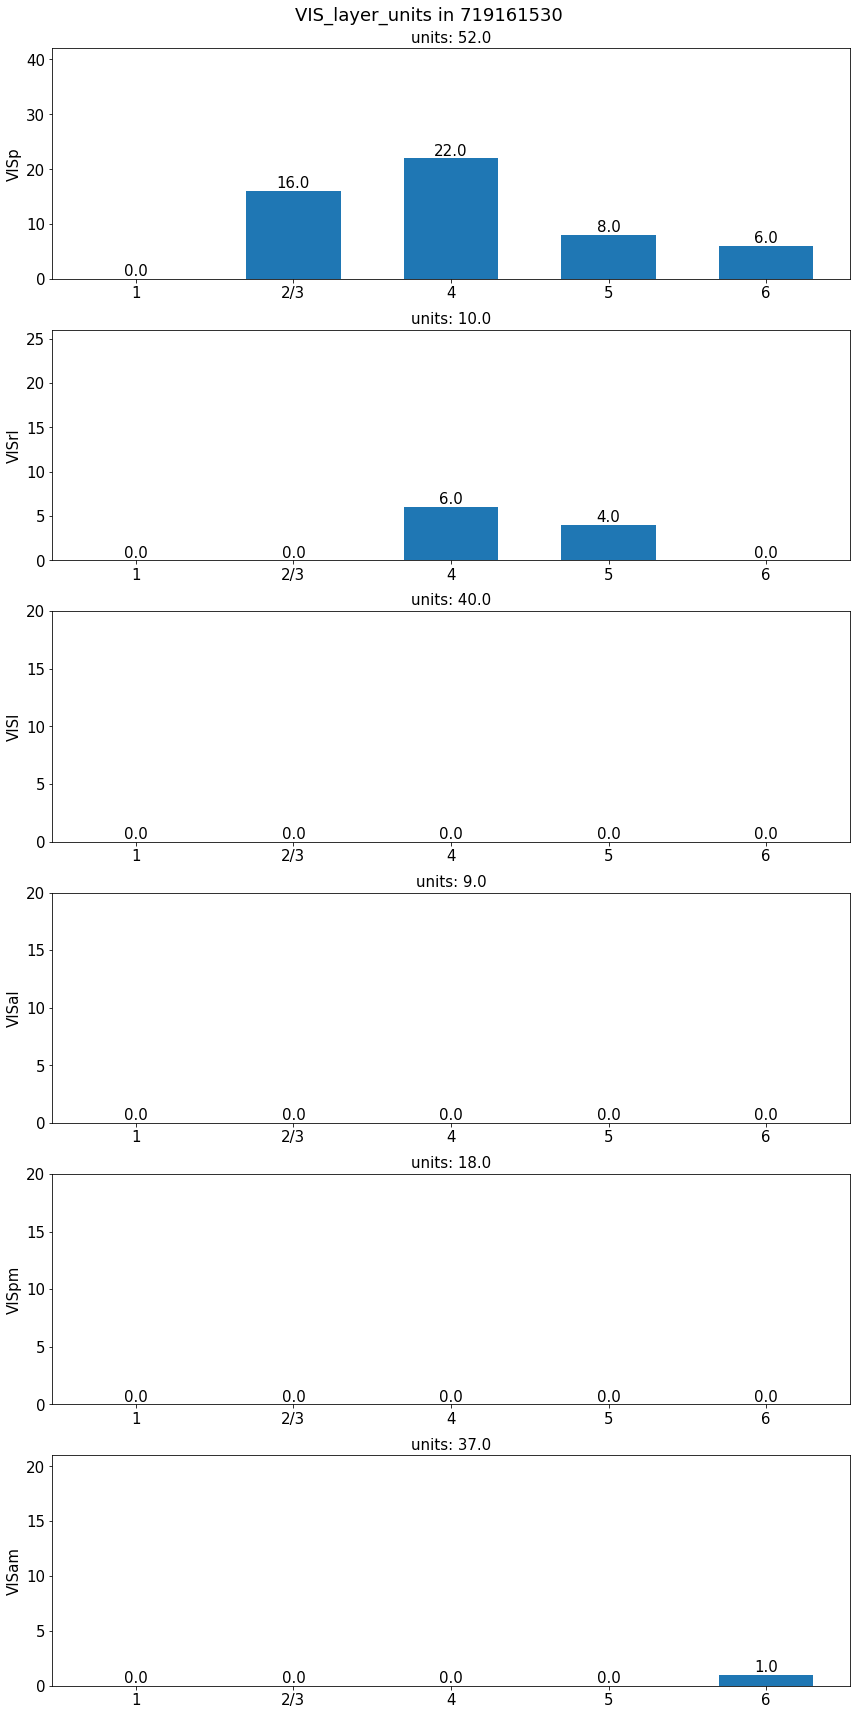

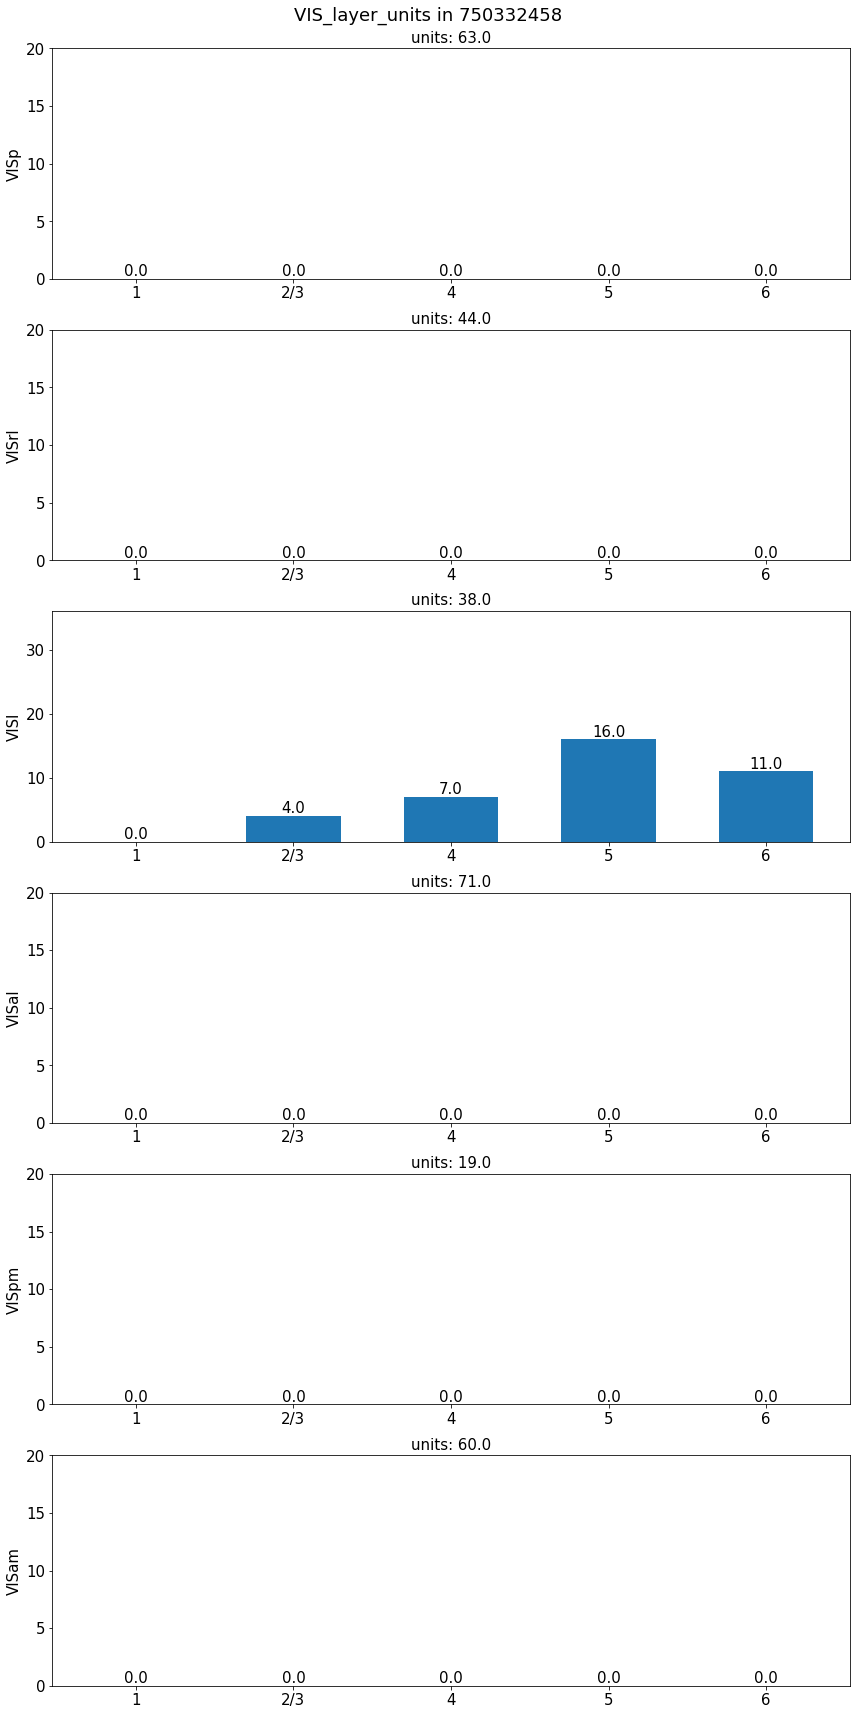

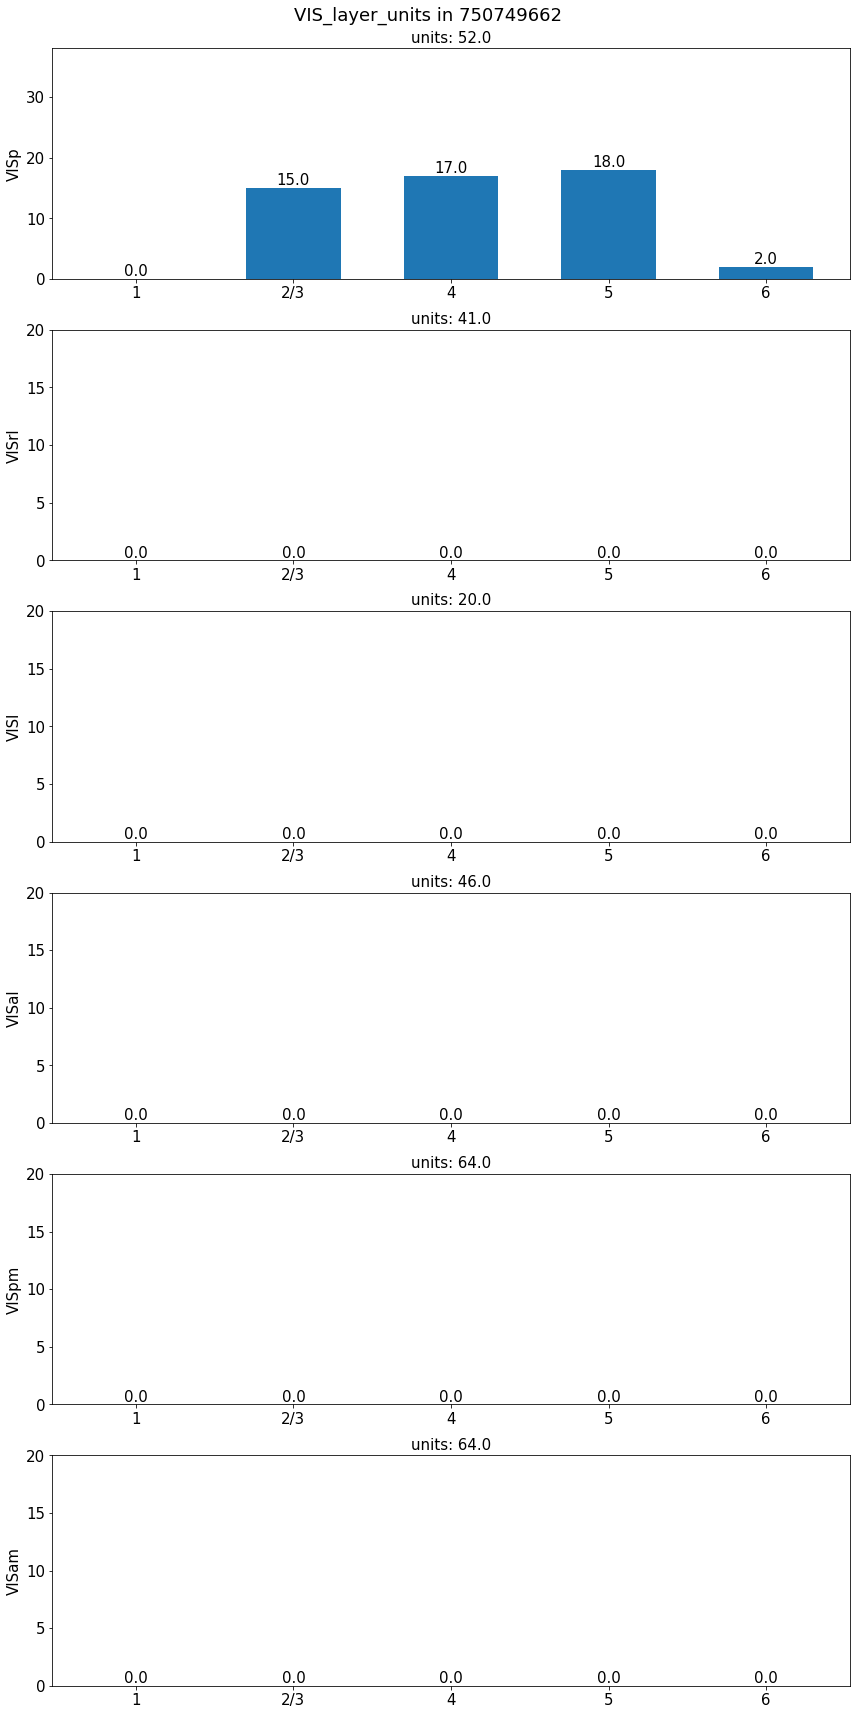

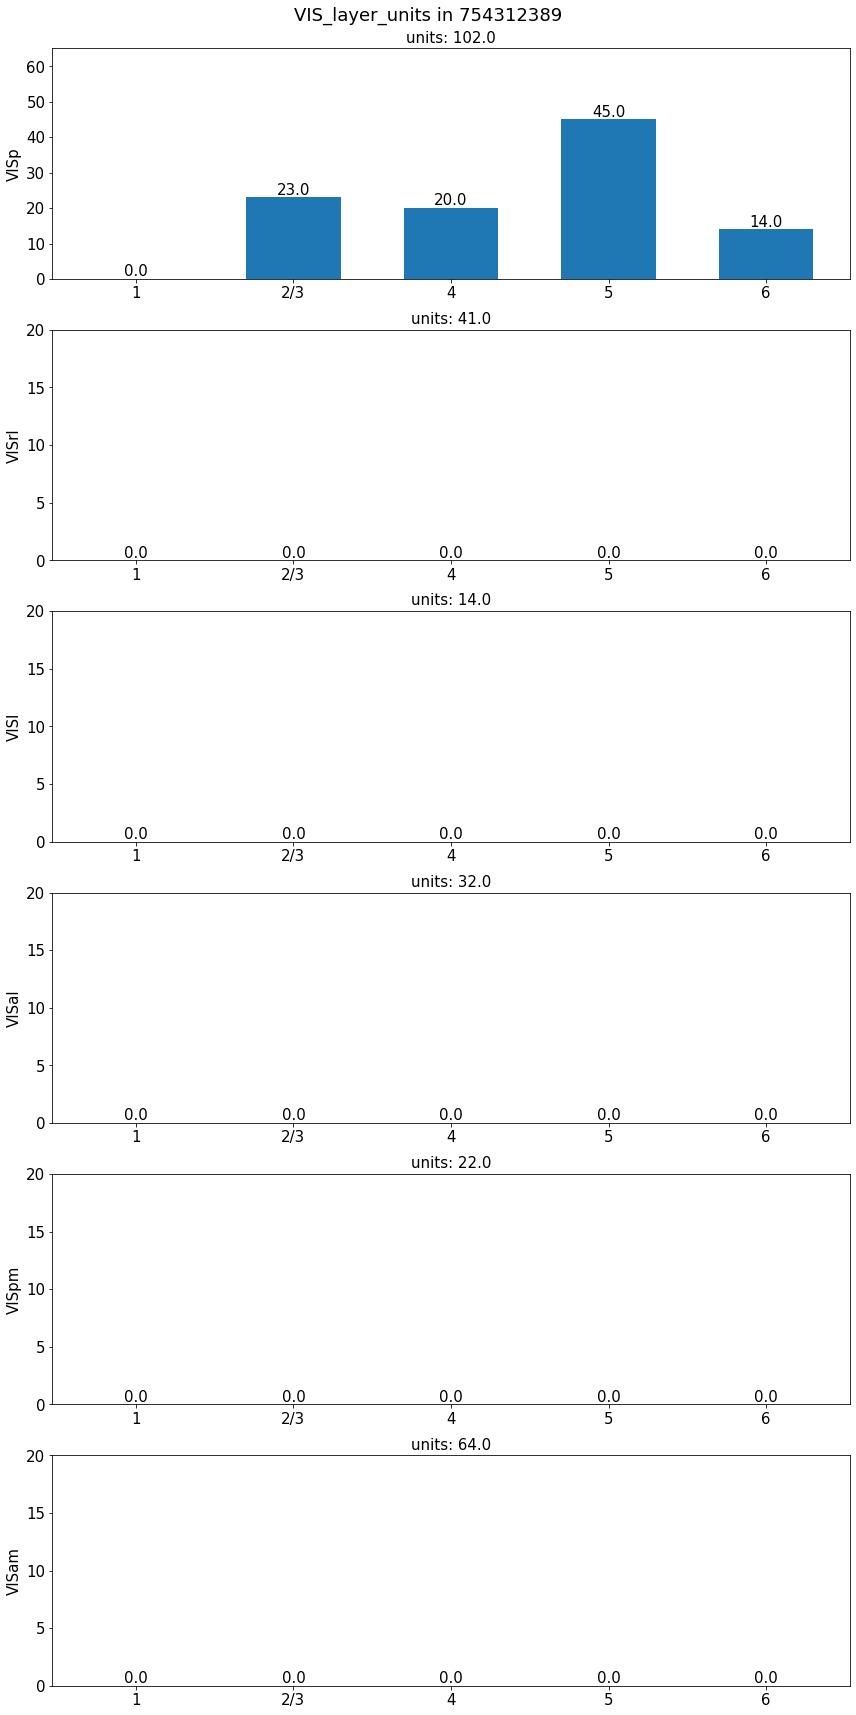

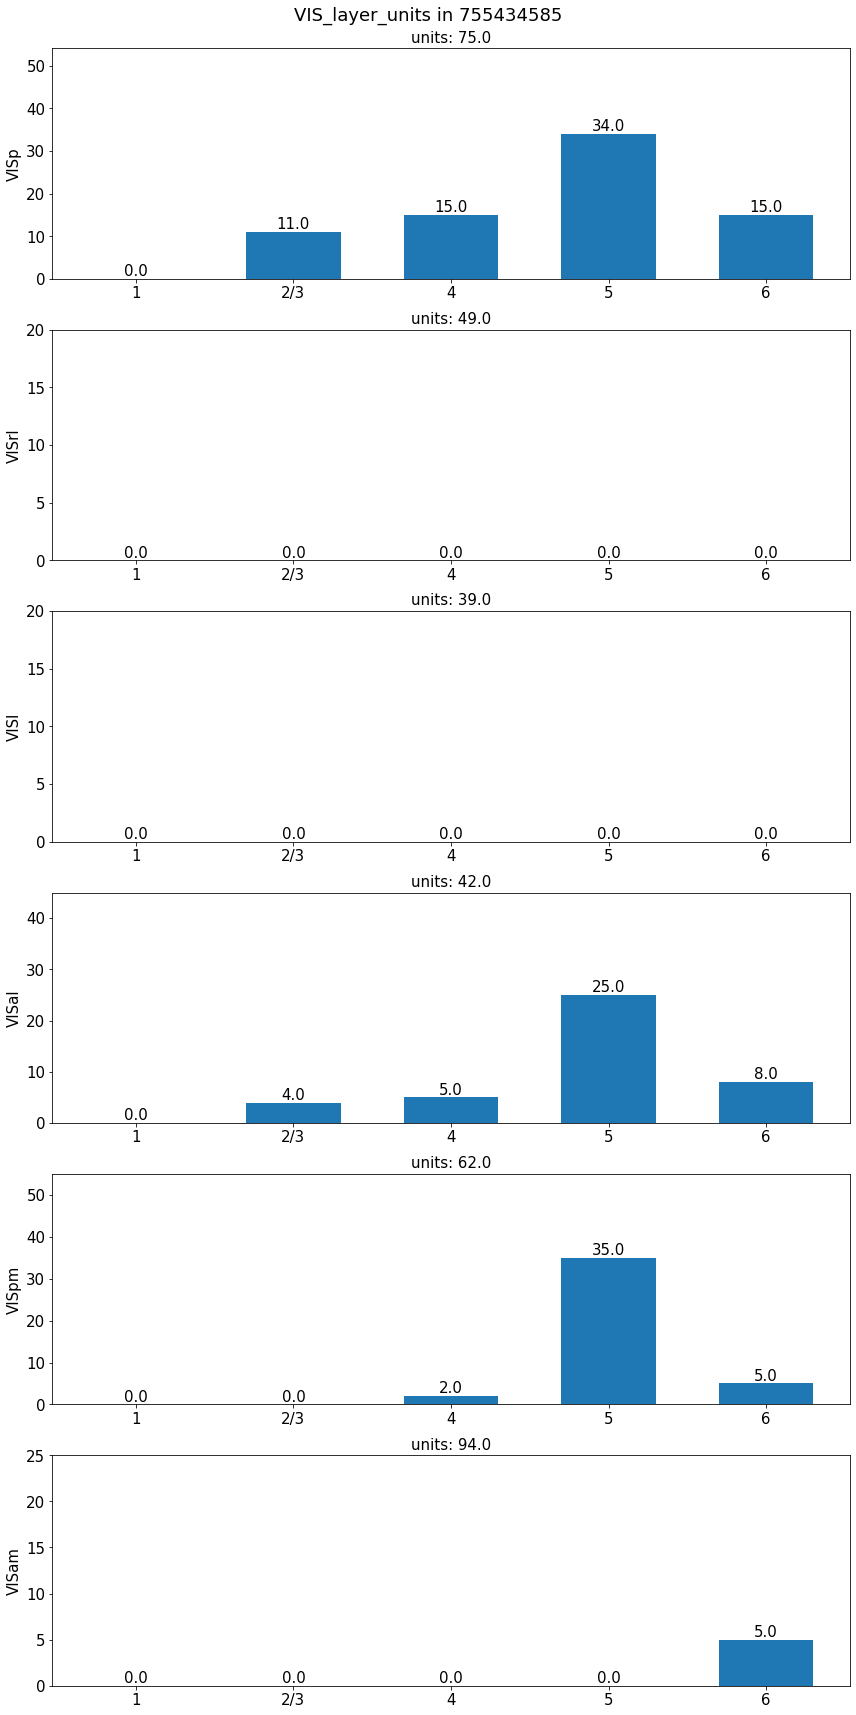

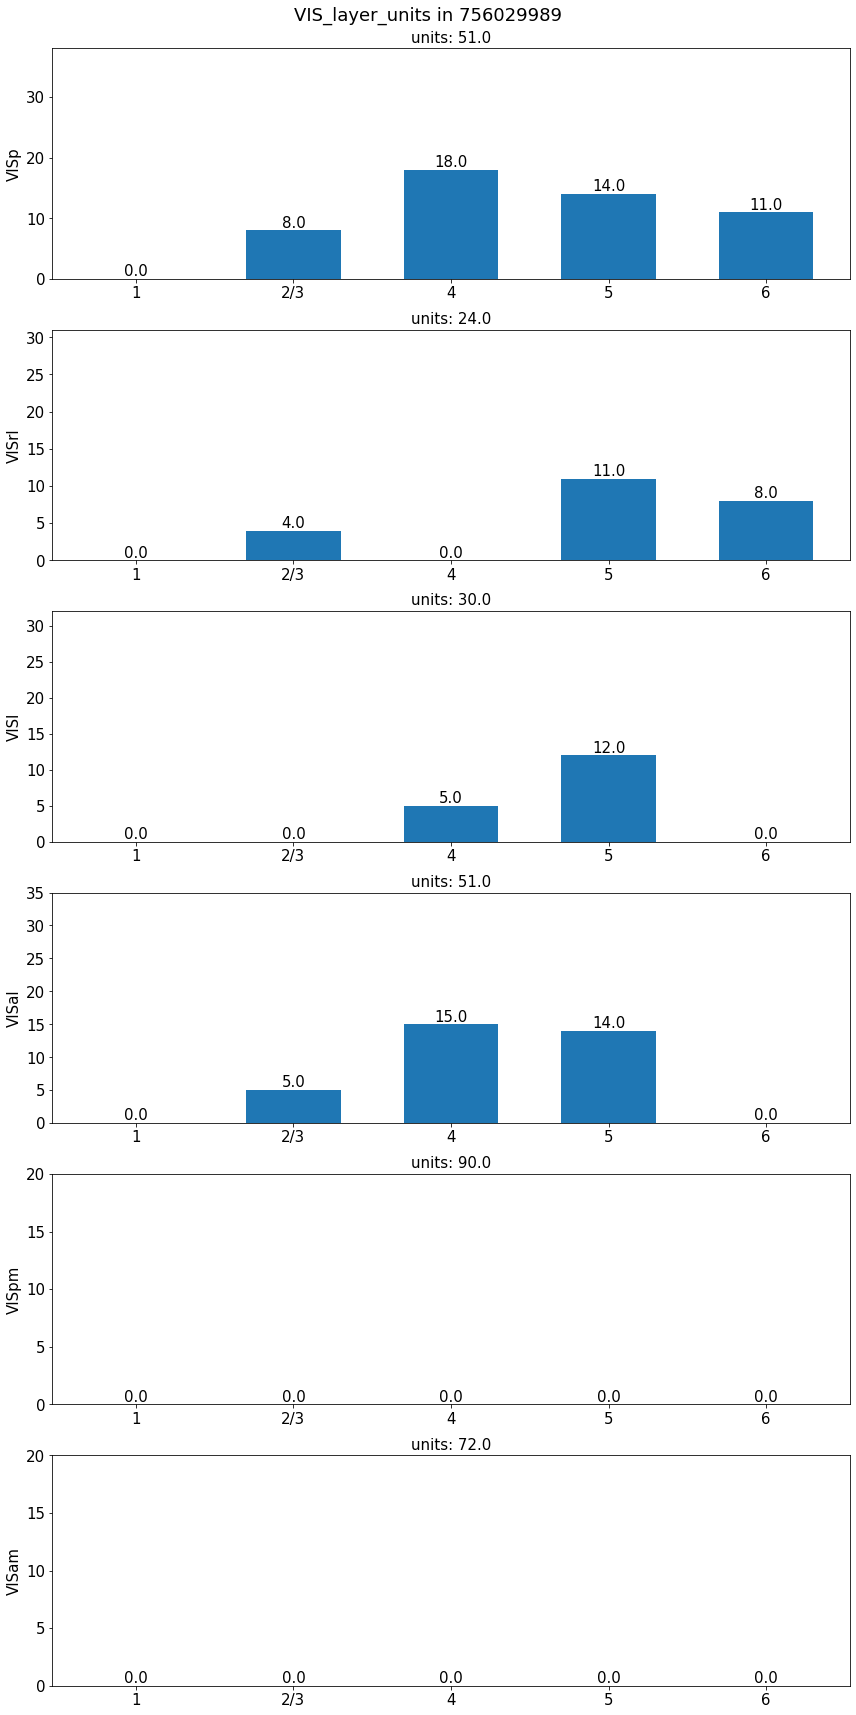

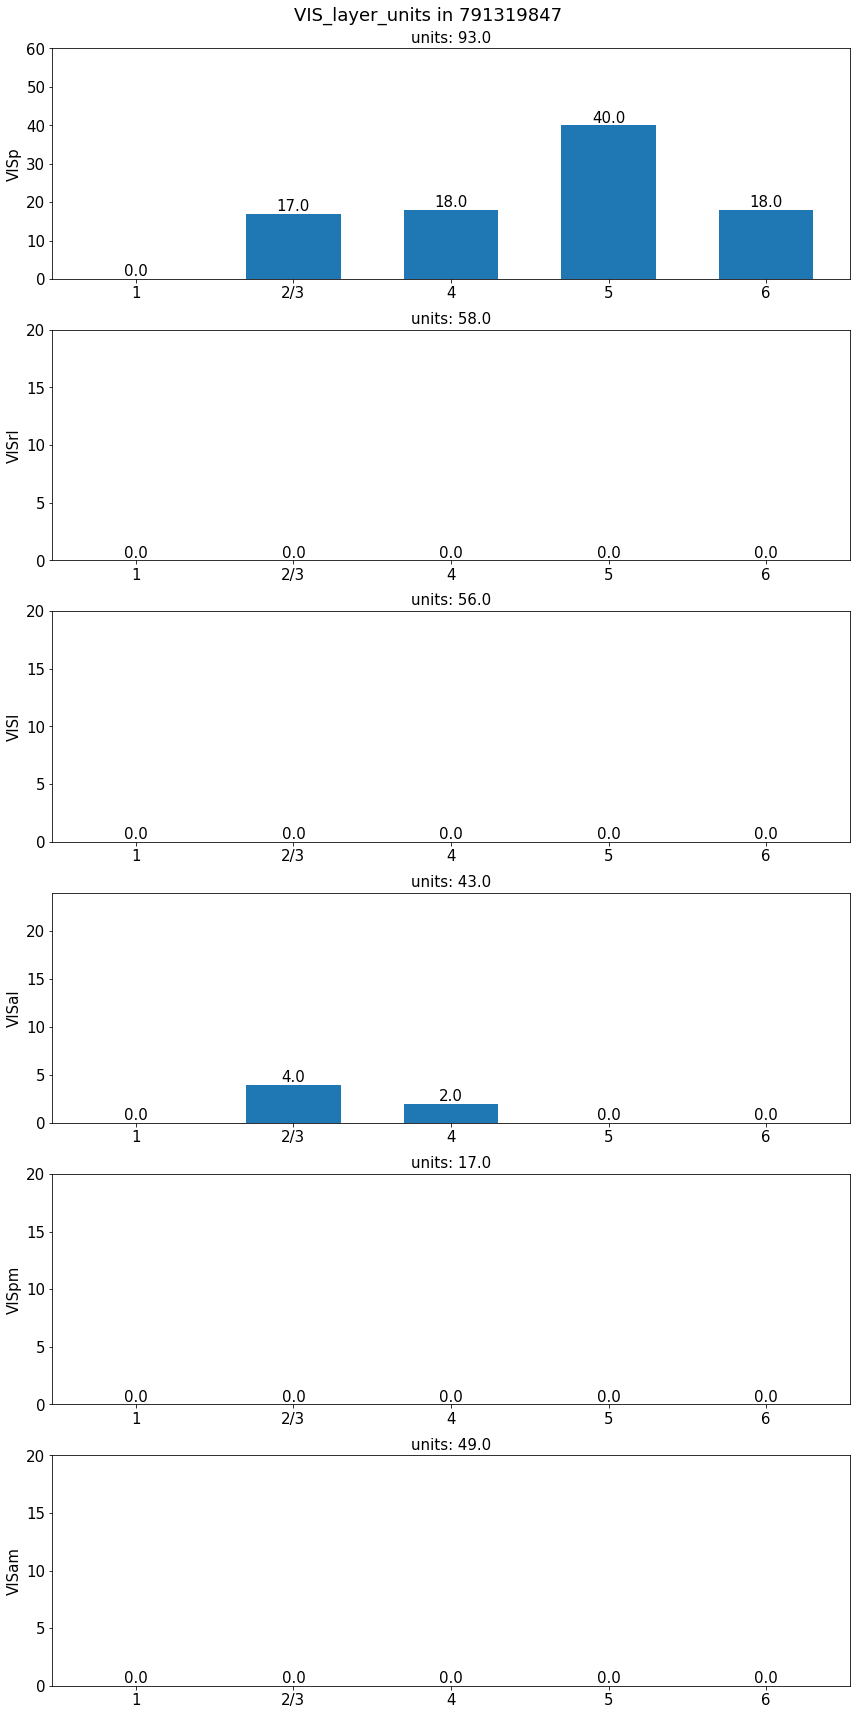

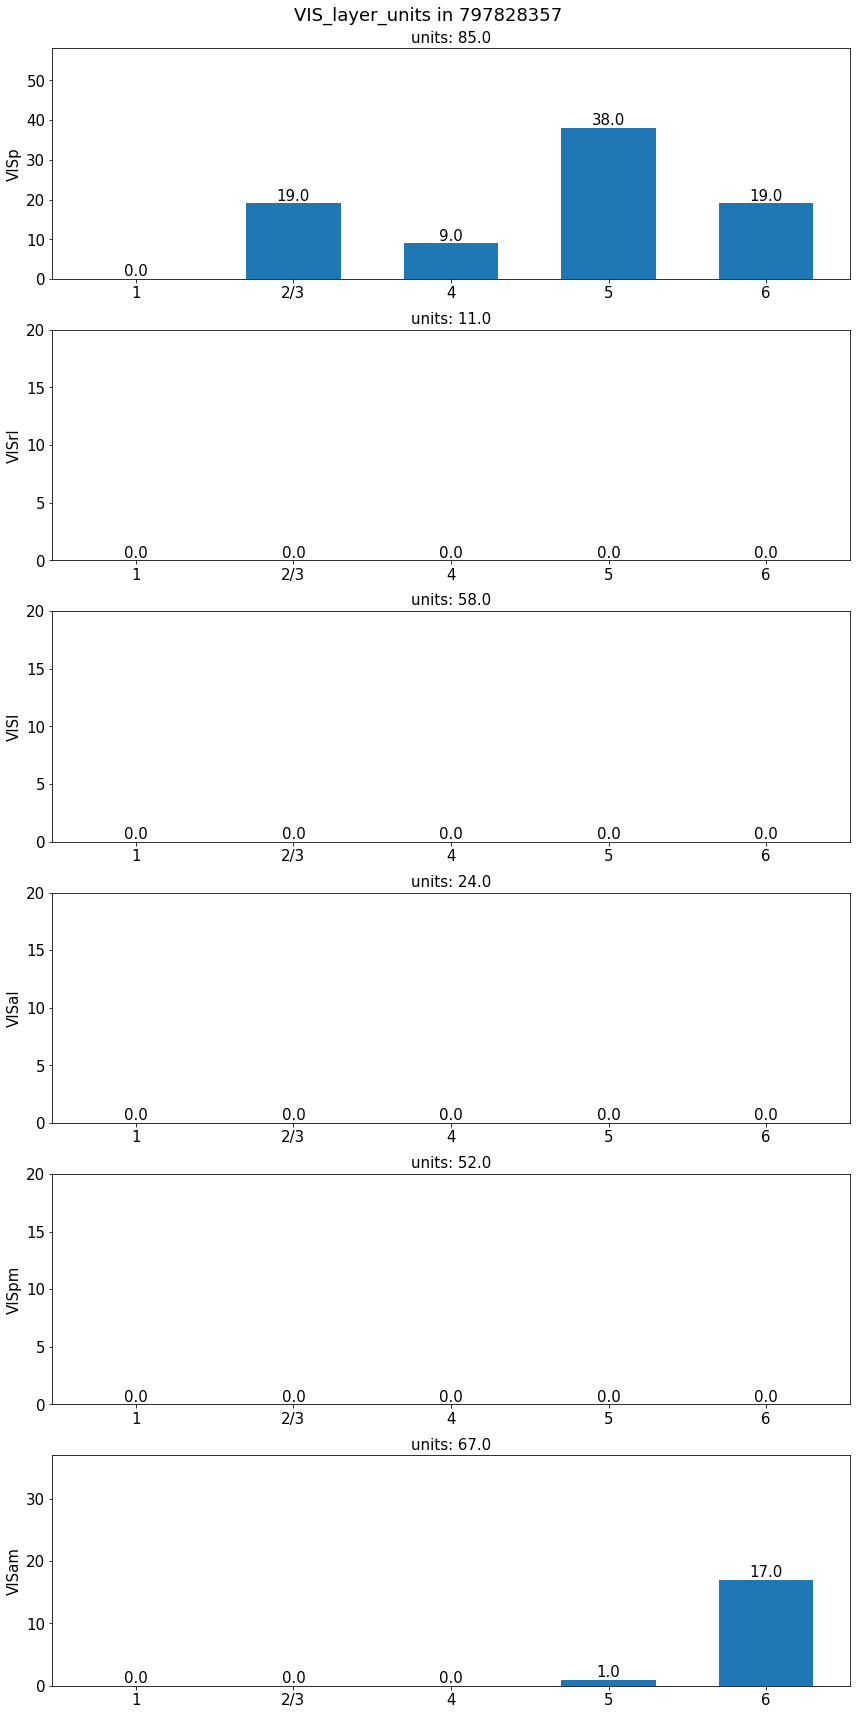

In [8]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
layers = ['1', '2/3', '4', '5', '6']
CCF_range_VIS = np.load('CCF_range_VIS.npy', allow_pickle=True).item()

for i, session_id in enumerate(session_ids):
    session = selected_sessions[session_id]
    VIS_layer_units = get_VIS_layer_units(session, areas, layers, CCF_range_VIS)
    # np.save('VIS_layer_units_'+f'{session_id}', VIS_layer_units)
    VIS_layer_units_num = get_layer_units_num(areas, layers, VIS_layer_units)
    units_areas = np.load('units_areas_755434585.npy')[i]
    plot_VIS_layer_units(areas, layers, VIS_layer_units_num, units_areas, session_id)

* explore information flow across layers

In [9]:
def spike_matrix_layer(area, layer, stim_table, layer_units, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    layer_units = layer_units[area][layer]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=layer_units
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def get_design_matrix_layer(area, layer, stim_table, layer_units):
    """get_design_matrix design_matrix for further analysis

    Reshape response_matrix from (stims, bins, units) to (stims*bins, units)/(n_samples, units)

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        design_matrix, shape (n_samples, units)
    """

    response_matrix = spike_matrix_layer(area=area, layer=layer, stim_table=stim_table, layer_units=layer_units)
    design_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return design_matrix

In [10]:
def corr_area_pairs(X_a, X_b, n_components=3):
    """corr_area_pairs cca between two areas' design matrix, X_a and X_b

    Arguments:
        X_a -- design matrix of one area, shape (stims*bins, units)
        X_b -- design matrix of one area, shape (stims*bins, units)

    Keyword Arguments:
        n_components -- num of canonical dimensions (default: {3})

    Returns:
        corr_z, correlation of latent variables, shape (n_components,)
        w_a, projection matrix used to transform X_a, shape (units_a, n_components)
        w_b, projection matrix used to transform X_b, shape (units_b, n_components) 
        z_a, canonical variables after projection X_a with w_a, shape (n_samples, n_components)
        z_b, canonical variables after projection X_b with w_b, shape (n_samples, n_components)
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) # latent variables

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

def CCA_across_layers(area, layers, stim_table, layer_units, component=0):
    
    layers_corr_matrix = np.empty([len(layers), len(layers)])

    for i in range(len(layers)):
        for j in range(len(layers)):
            des_mat_i = get_design_matrix_layer(area=area, layer=layers[i], stim_table=stim_table, layer_units=layer_units)
            des_mat_j = get_design_matrix_layer(area=area, layer=layers[j], stim_table=stim_table, layer_units=layer_units)

            corr_ij, _, _ = corr_area_pairs(des_mat_i, des_mat_j)
            layers_corr_matrix[i, j] = corr_ij[component]

    return layers_corr_matrix

def plot_CCA_across_areas(area, layers, layers_corr_matrix):

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(layers_corr_matrix)

    ax.set_xticks(range(len(layers))+np.array([0.5]))
    ax.set_xticklabels(layers)
    ax.set_yticks(range(len(layers))+np.array([0.5]))
    ax.set_yticklabels(layers)
    ax.set_title(f'CCA 1st correlation across layers in {area}')

    f.colorbar(im)

[[1.         0.741494   0.70617056 0.34149888]
 [0.74149401 1.         0.76203893 0.54751344]
 [0.70617056 0.76203891 1.         0.75716073]
 [0.34149985 0.54751303 0.75716073 1.        ]]


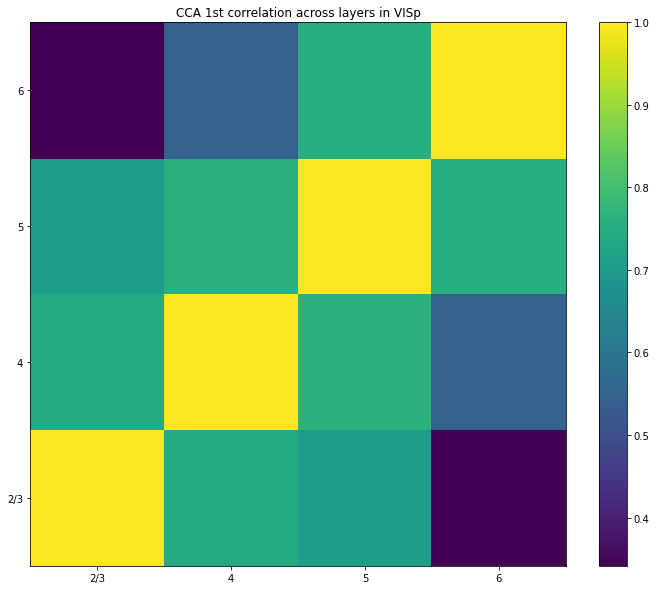

In [25]:
session_id = 755434585
session = selected_sessions[session_id]
area = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')
layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()

layers_corr_matrix = CCA_across_layers(area=area, layers=layers, stim_table=drift_stim_table, layer_units=layer_units)
print(layers_corr_matrix)
plot_CCA_across_areas(area, layers, layers_corr_matrix)

In [23]:
# def get_layer_units_sessions(areas, layers, session_ids):

#     layer_units_sessions = {}

#     for i, area in enumerate(areas):
#         layer_units_sessions[area] = {}
#         for j, layer in enumerate(layers):
#             layer_units_sessions[area][layer] = np.array([])


#     for i, area in enumerate(areas):
#         for j, layer in enumerate(layers):
#             for k, session_id in enumerate(session_ids):
#                 layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()
#                 units = np.append(layer_units_sessions[area][layer], layer_units[area][layer])
#                 layer_units_sessions[area][layer] = units

#     return layer_units_sessions

# areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
# layers = ['1', '2/3', '4', '5', '6']
# layer_units_sessions = get_layer_units_sessions(areas, layers, session_ids)

In [37]:
def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def cca_delay_layers(area, layer_1, layer_2, layer_units, stim_table, trial_len=2000, window_len=200, step_len=40, bin_len=50, max_delay=100):

    # correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

    raster_bin = 1  # bin time, 1ms

    spike_raster_1 = spike_matrix_layer(area, layer_1, stim_table=stim_table, layer_units=layer_units, bin=raster_bin/1000)
    spike_raster_2 = spike_matrix_layer(area, layer_2, stim_table=stim_table, layer_units=layer_units, bin=raster_bin/1000)

    step_points = np.arange(0, trial_len-window_len, step_len)

    corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

    for step_id, step in enumerate(step_points):
        t_1 = step
        window_1 = np.arange(t_1, t_1+window_len)
        spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
        spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                                spike_counts_1.shape[2]])

        slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

        for slide_id, slide in enumerate(slide_points):
            t_2 = slide
            window_2 = np.arange(t_2, t_2+window_len)
            spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
            spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                                spike_counts_2.shape[2]])

            corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
            corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]

    # print(corr_matrix_delay.shape)
    # mask no correlation value
    corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)

    return corr_matrix_delay


def get_feedforward_ratio(corr_matrix_delay, step=5):

    max_delay = int(corr_matrix_delay.shape[1]/2)
        
    negative_delay_area = np.sum(corr_matrix_delay[step, :max_delay])
    positive_delay_area = np.sum(corr_matrix_delay[step, max_delay:])

    feedforward_ratio = (positive_delay_area-negative_delay_area)/(positive_delay_area+negative_delay_area)

    return feedforward_ratio

In [38]:
def plot_corr_matrix_delay_layers(area, layers, corr_delay_matrix_layers):

    f, axes = plt.subplots(nrows=len(layers), ncols=len(layers), sharex=True, sharey=True, figsize=(24, 25))

    for i, layer_1 in enumerate(layers):
        for j, layer_2 in enumerate(layers):

            layers_key = area + '_' + layer_1 + '_' + layer_2
            corr_matrix_delay = corr_delay_matrix_layers[layers_key]

            max_delay = int(corr_matrix_delay.shape[1]/2)
            axes[i, j].pcolormesh(corr_matrix_delay)

            if i == 0:
                axes[i, j].set_title(f'{layer_2}', fontsize=15)
            if j == 0:
                axes[i, j].set_ylabel(f'{layer_1}', fontsize=15)
                # axes[i, j].yaxis.set_label_position("right")
            if i == j:
                axes[i, j].set_xticks(range(0, corr_matrix_delay.shape[1], 20))
                axes[i, j].set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))

    f.suptitle('correlation_delay across layers', verticalalignment='bottom', fontsize=18)
    # f.colorbar(im)
    plt.tight_layout()
    plt.show

    return

def plot_corr_delay_matrix_layer(corr_matrix_delay, layer_1, layer_2):
    
    max_delay = int(corr_matrix_delay.shape[1]/2)

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(corr_matrix_delay)

    ax.set_xticks(range(0, corr_matrix_delay.shape[1], 20))
    ax.set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
    # ax.set_yticks(range(len(areas))+np.array([0.5]))
    # ax.set_yticklabels(areas)
    ax.set_xlabel('delay, ms', fontsize=15)
    ax.set_ylabel('step, *40ms', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_title(f'correlation_delay between {layer_1} & {layer_2}', fontsize=15)

    fig.colorbar(im)
    plt.show

    return

def plot_corr_delay_layer(corr_matrix_delay, layer_1, layer_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    step_list = [5, 10, 20, 30, 39]

    fig, axes = plt.subplots(nrows=len(step_list), ncols=1, figsize=(12, 24))

    for i, step in enumerate(step_list):
        
        axes[i].plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
        axes[i].set_ylabel('corrlelation', fontsize=15)
        axes[i].set_xlabel('delay, ms', fontsize=15)
        axes[i].tick_params(axis='both', labelsize=15)
        axes[i].set_title(f'correlation_delay in step {step} between {layer_1} & {layer_2}', fontsize=15)

    plt.tight_layout()
    plt.show()

    return

def plot_corr_step_layer(corr_matrix_delay, layer_1, layer_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    delay_list = [-80, -40, 0, 40, 80]

    fig, axes = plt.subplots(nrows=len(delay_list), ncols=1, figsize=(12, 24))

    for i, delay in enumerate(delay_list):
        
        axes[i].plot(range(corr_matrix_delay.shape[0]), corr_matrix_delay[:, delay+max_delay])
        axes[i].set_ylabel('corrlelation', fontsize=15)
        axes[i].set_xlabel('step, *40ms', fontsize=15)
        axes[i].tick_params(axis='both', labelsize=15)
        axes[i].set_title(f'correlation_step in delay {delay} between {layer_1} & {layer_2}', fontsize=15)

    plt.tight_layout()
    plt.show()

    return


def plot_feedforward_ratio_layer(corr_matrix_delay, layer_1, layer_2):

    step_list = [5, 10, 20, 30, 39]
    feedforward_ratio = np.zeros(len(step_list))

    for i, step in enumerate(step_list):

        feedforward_ratio[i] = get_feedforward_ratio(corr_matrix_delay, step=step)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(range(len(step_list)), feedforward_ratio)
    ax.set_xticks(ticks=np.arange(len(step_list))+[0.5])
    ax.set_xticklabels(step_list)
    ax.set_title(f'feedforward_ratio between {layer_1} & {layer_2}', fontsize=15)
    ax.set_xlabel('step, *40ms', fontsize=15)
    ax.set_ylabel('feedforward_ratio', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    
    plt.show

    return 

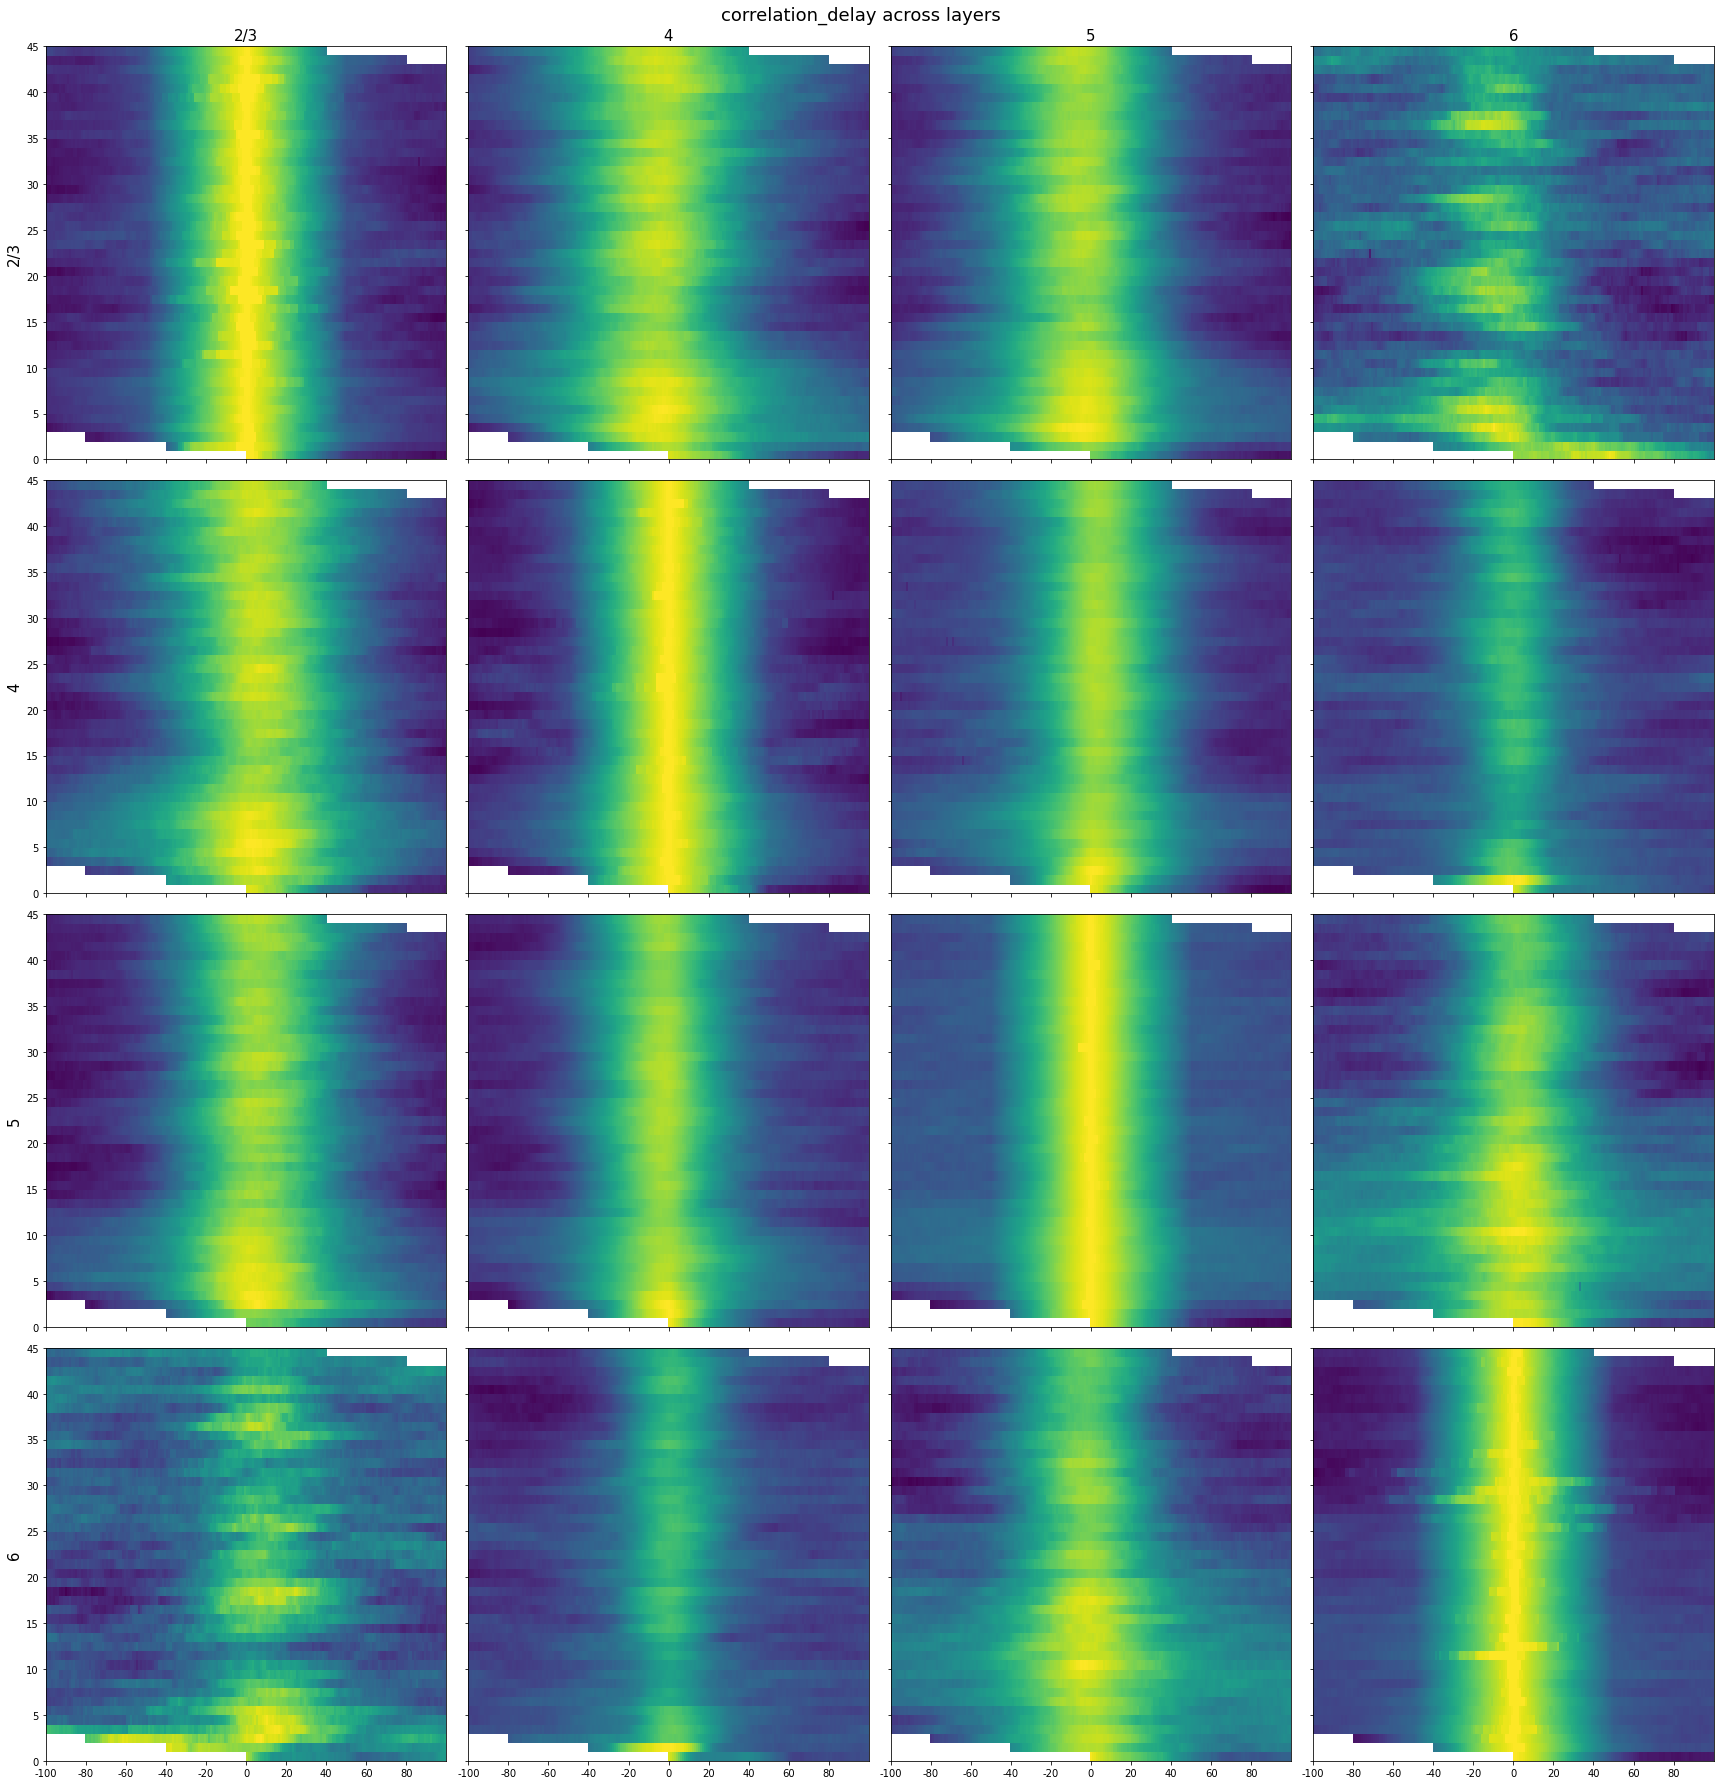

In [40]:
session_id = 755434585
session = selected_sessions[session_id]
area = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')
layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()

# corr_delay_matrix_layers = {}    # save corr_delay_matrix every two areas
# for i, layer_1 in enumerate(layers):
#     for j, layer_2 in enumerate(layers):
#         corr_matrix_delay = cca_delay_layers(area, layer_1, layer_2, layer_units, stim_table=drift_stim_table)
#         layers_key = area + '_' + layer_1 + '_' + layer_2
#         corr_delay_matrix_layers[layers_key] = corr_matrix_delay
#         print(layer_1, layer_2)
# np.save('corr_delay_matrix_layers_755434585', corr_delay_matrix_layers)

corr_delay_matrix_layers = np.load('corr_delay_matrix_layers_755434585.npy', allow_pickle=True).item()
for i, layer_1 in enumerate(layers):
    for j, layer_2 in enumerate(layers):
        layers_key = area + '_' + layer_1 + '_' + layer_2   
        corr_matrix_delay = corr_delay_matrix_layers[layers_key]

plot_corr_matrix_delay_layers(area, layers, corr_delay_matrix_layers)

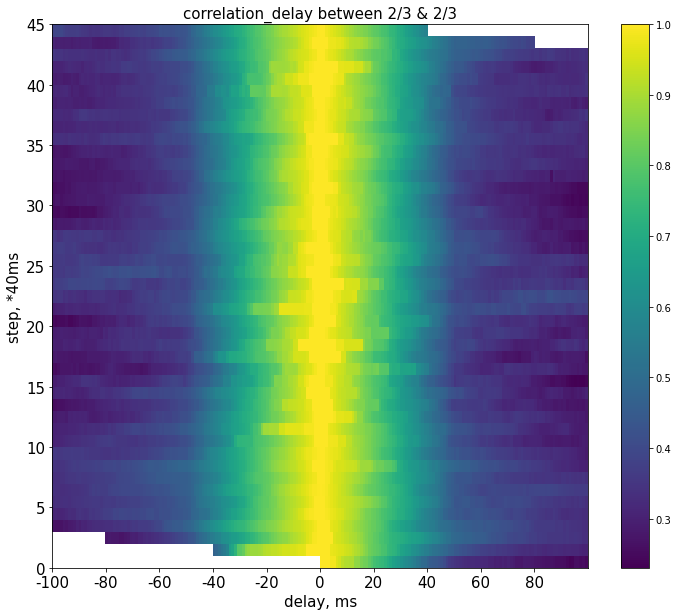

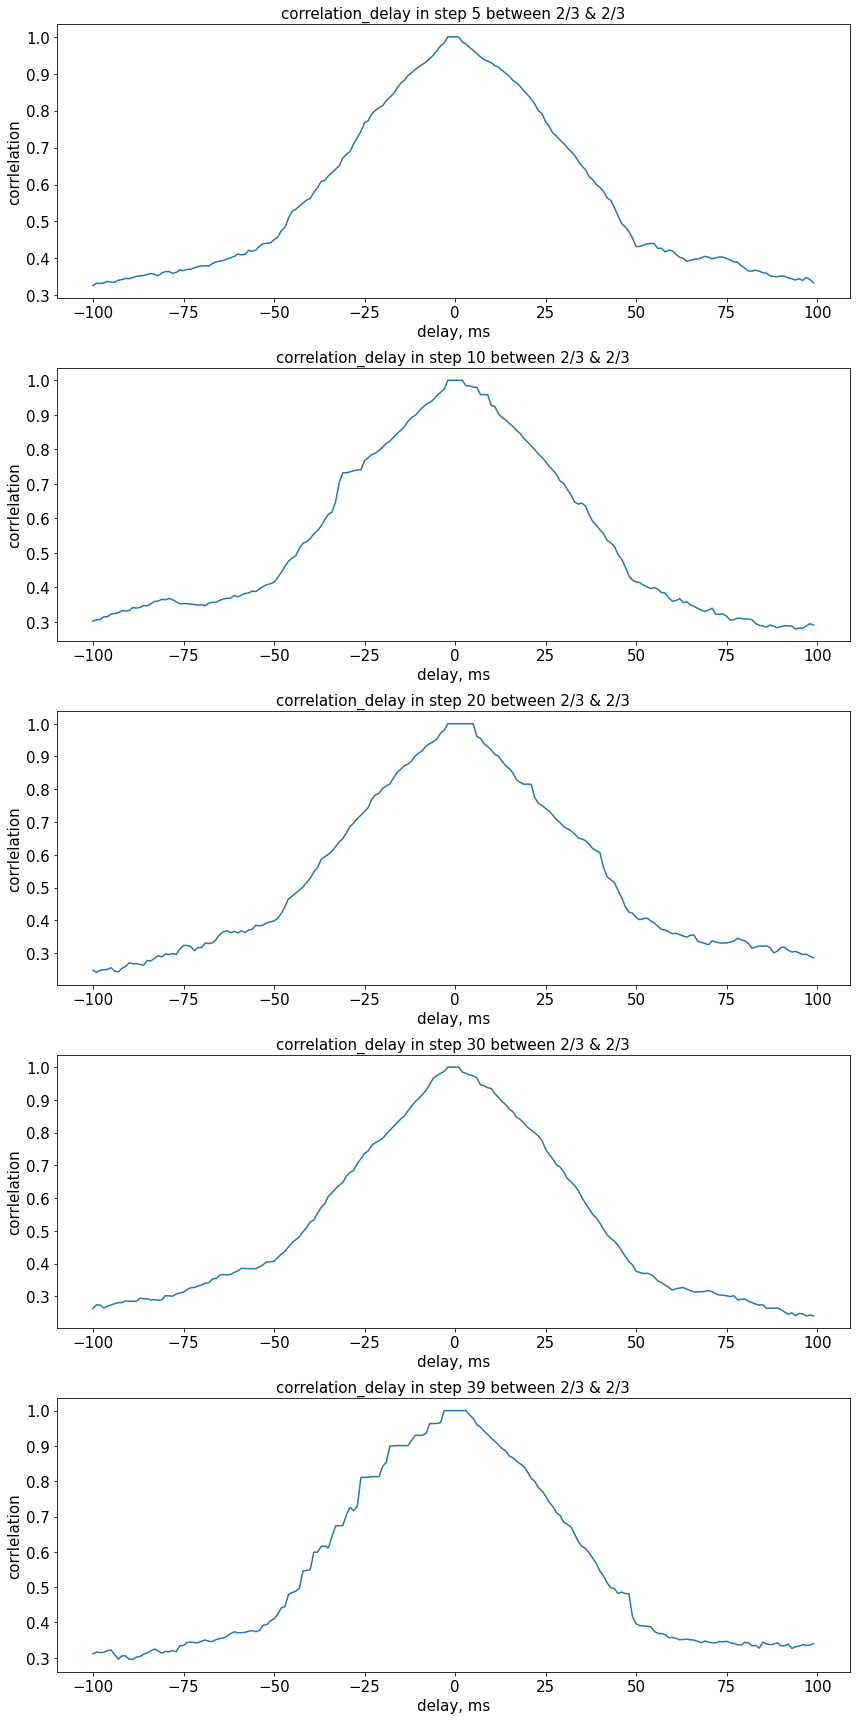

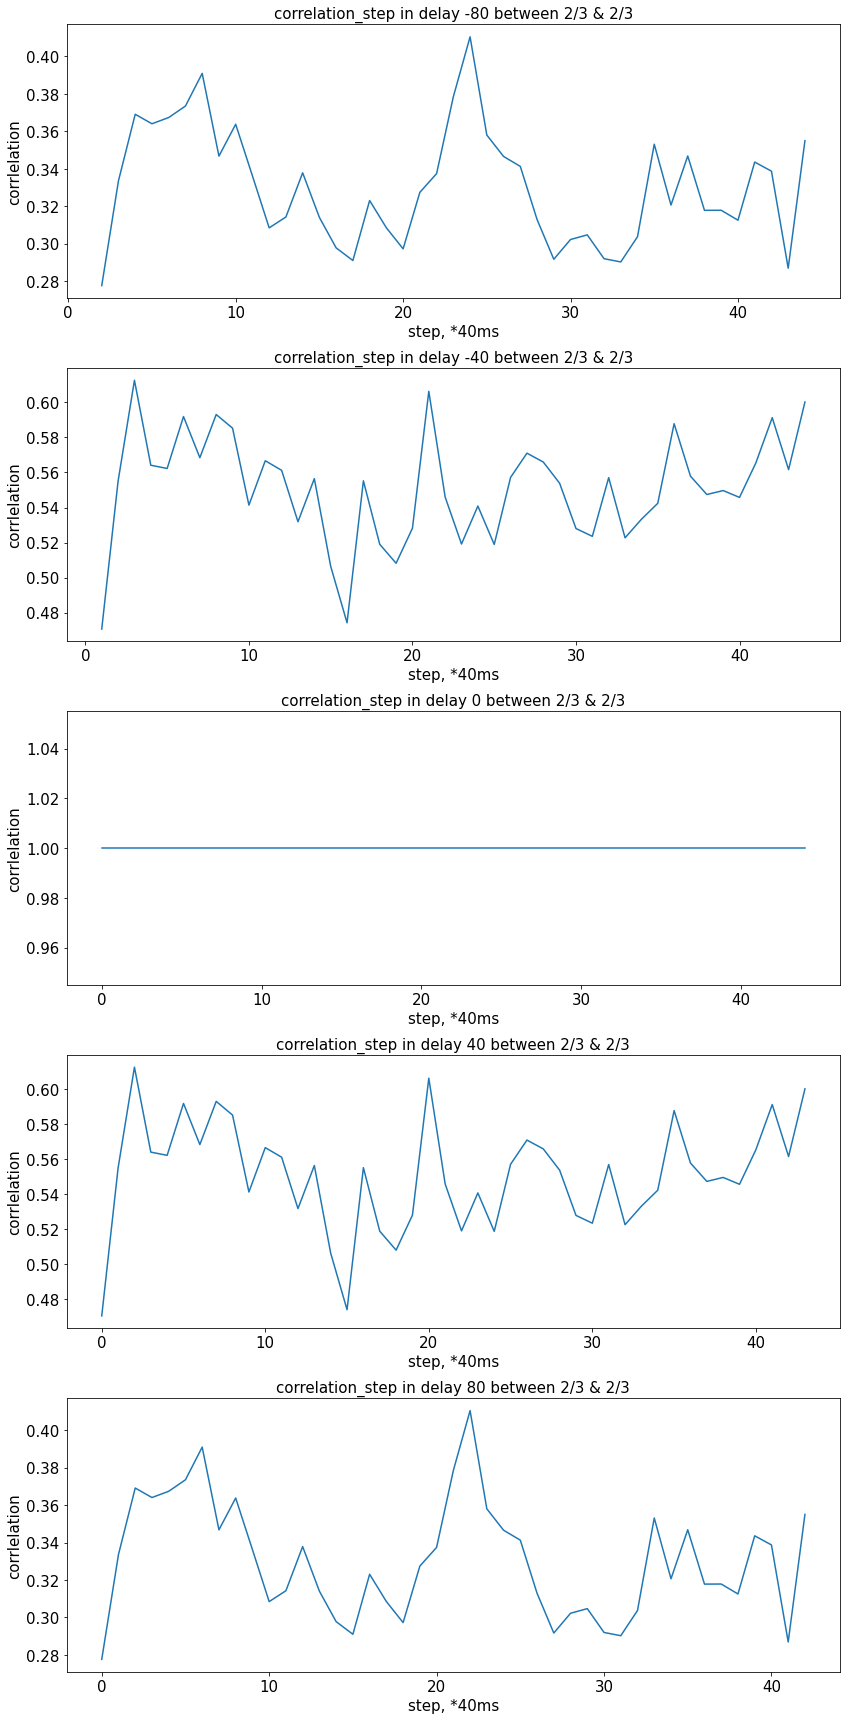

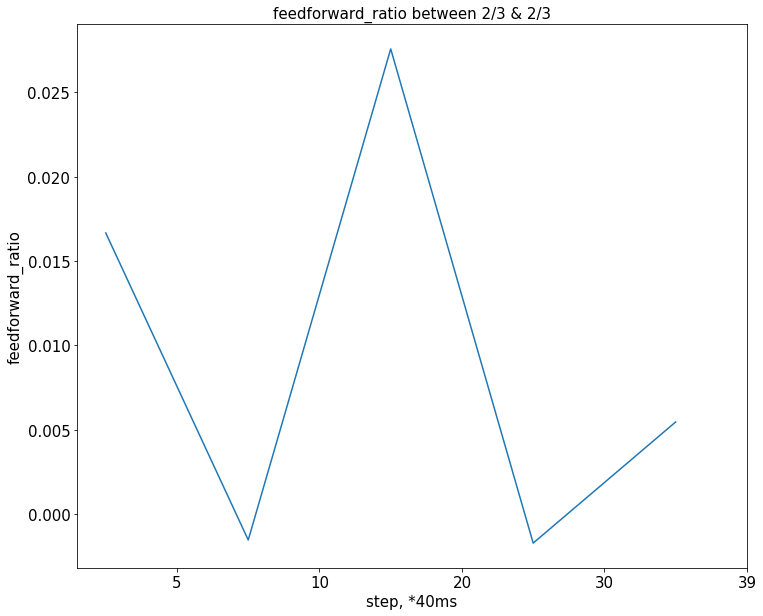

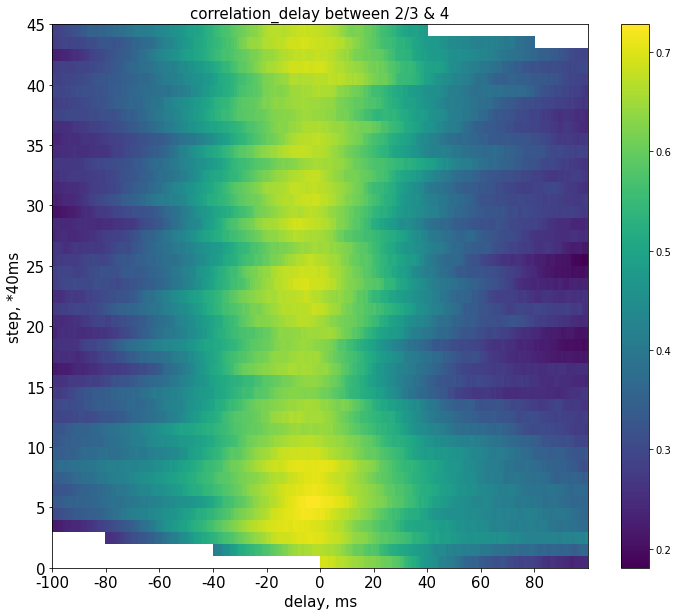

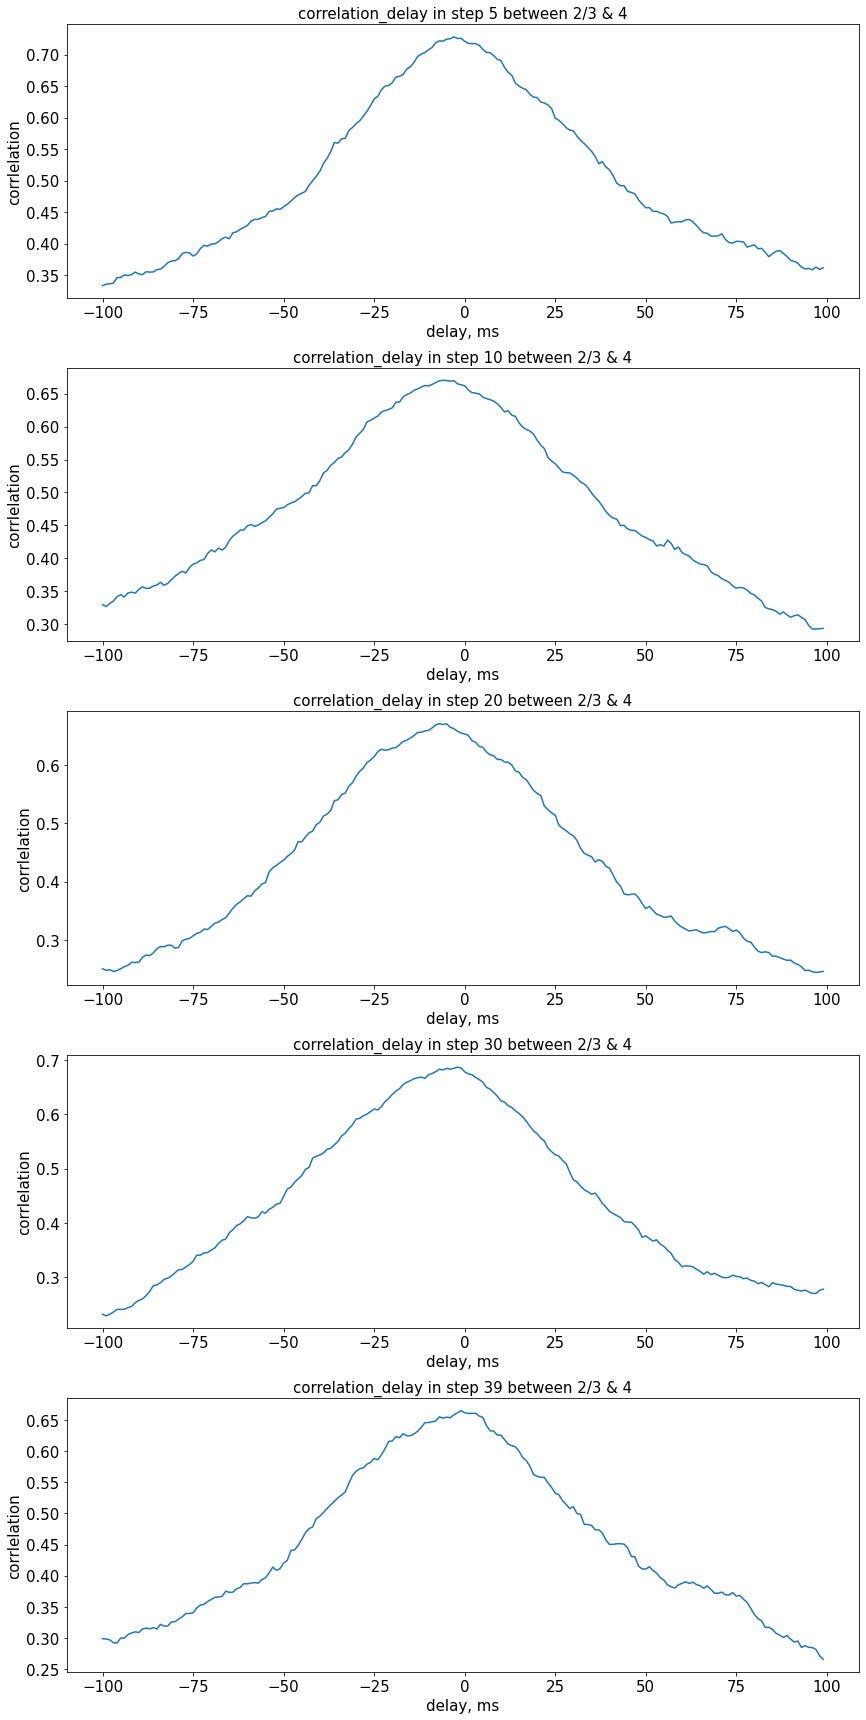

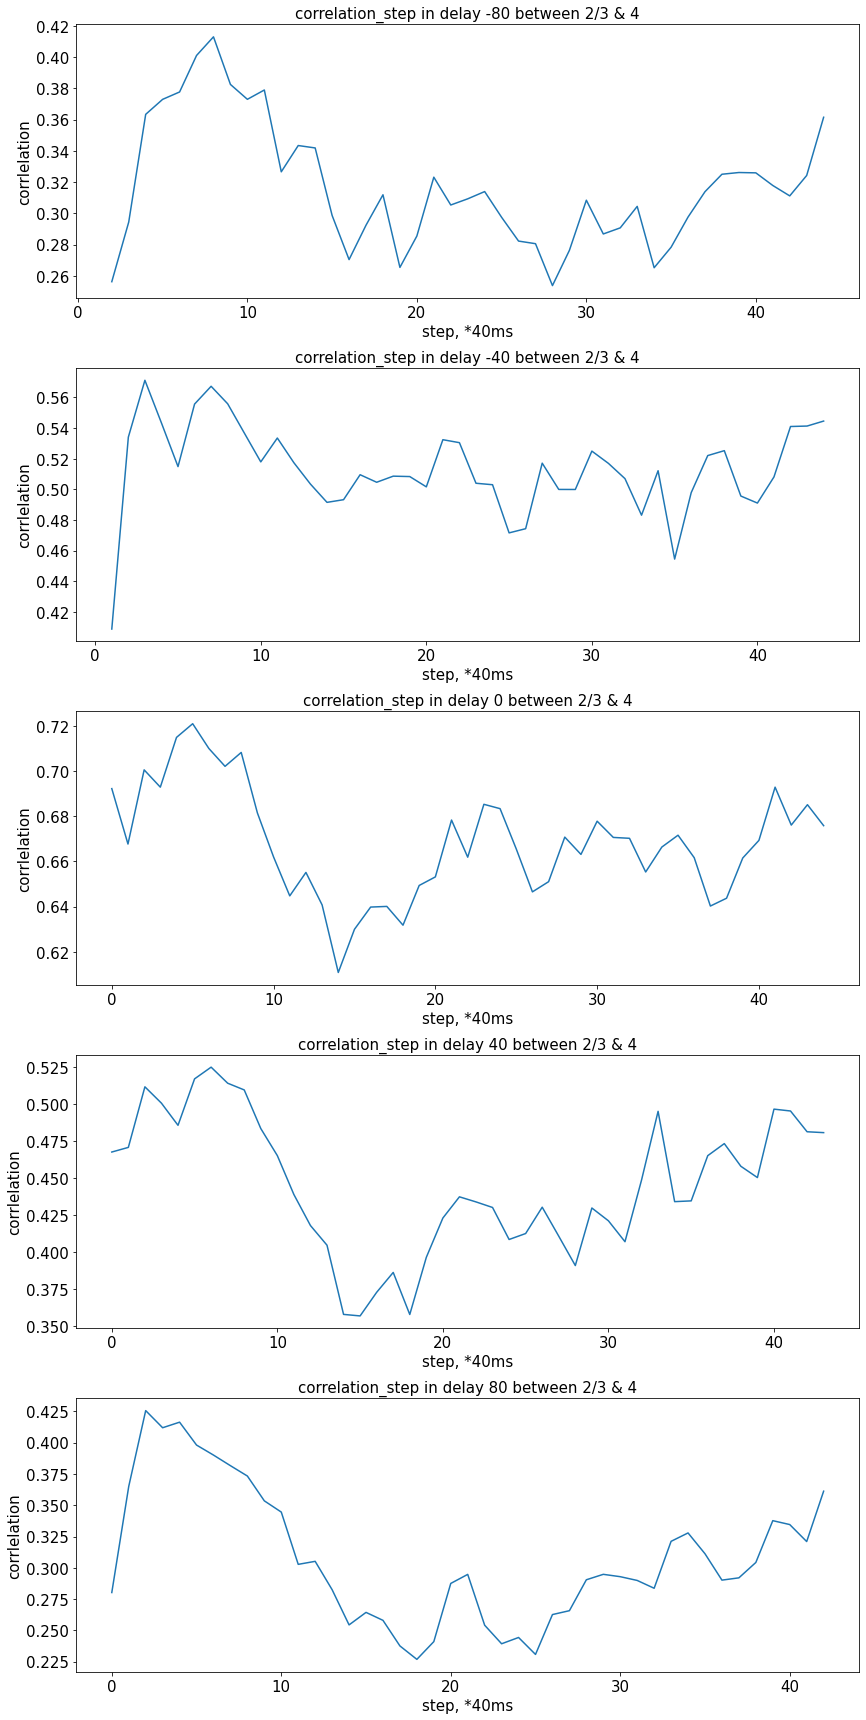

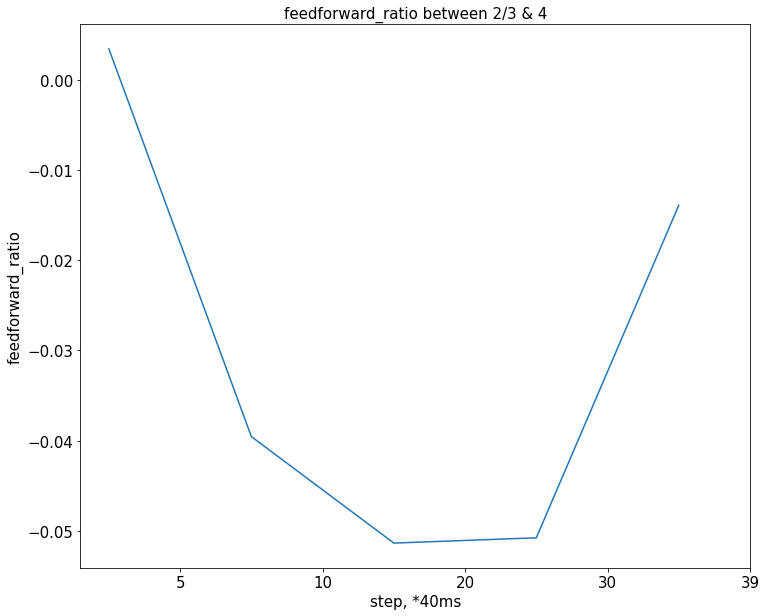

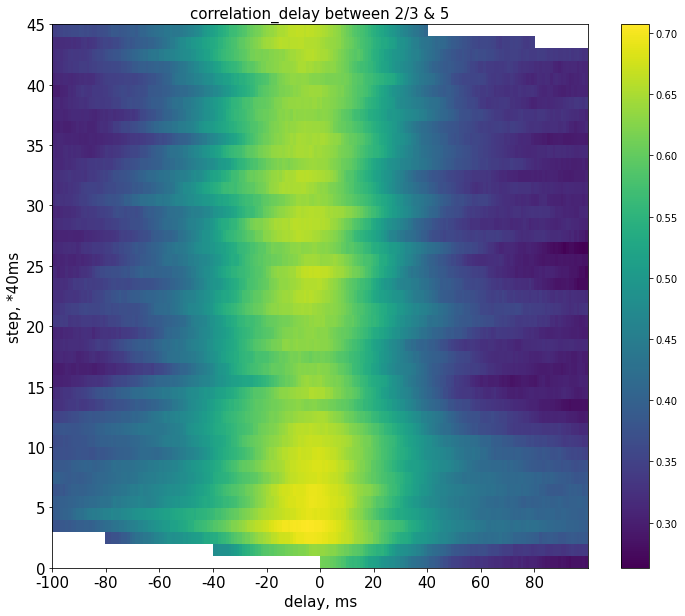

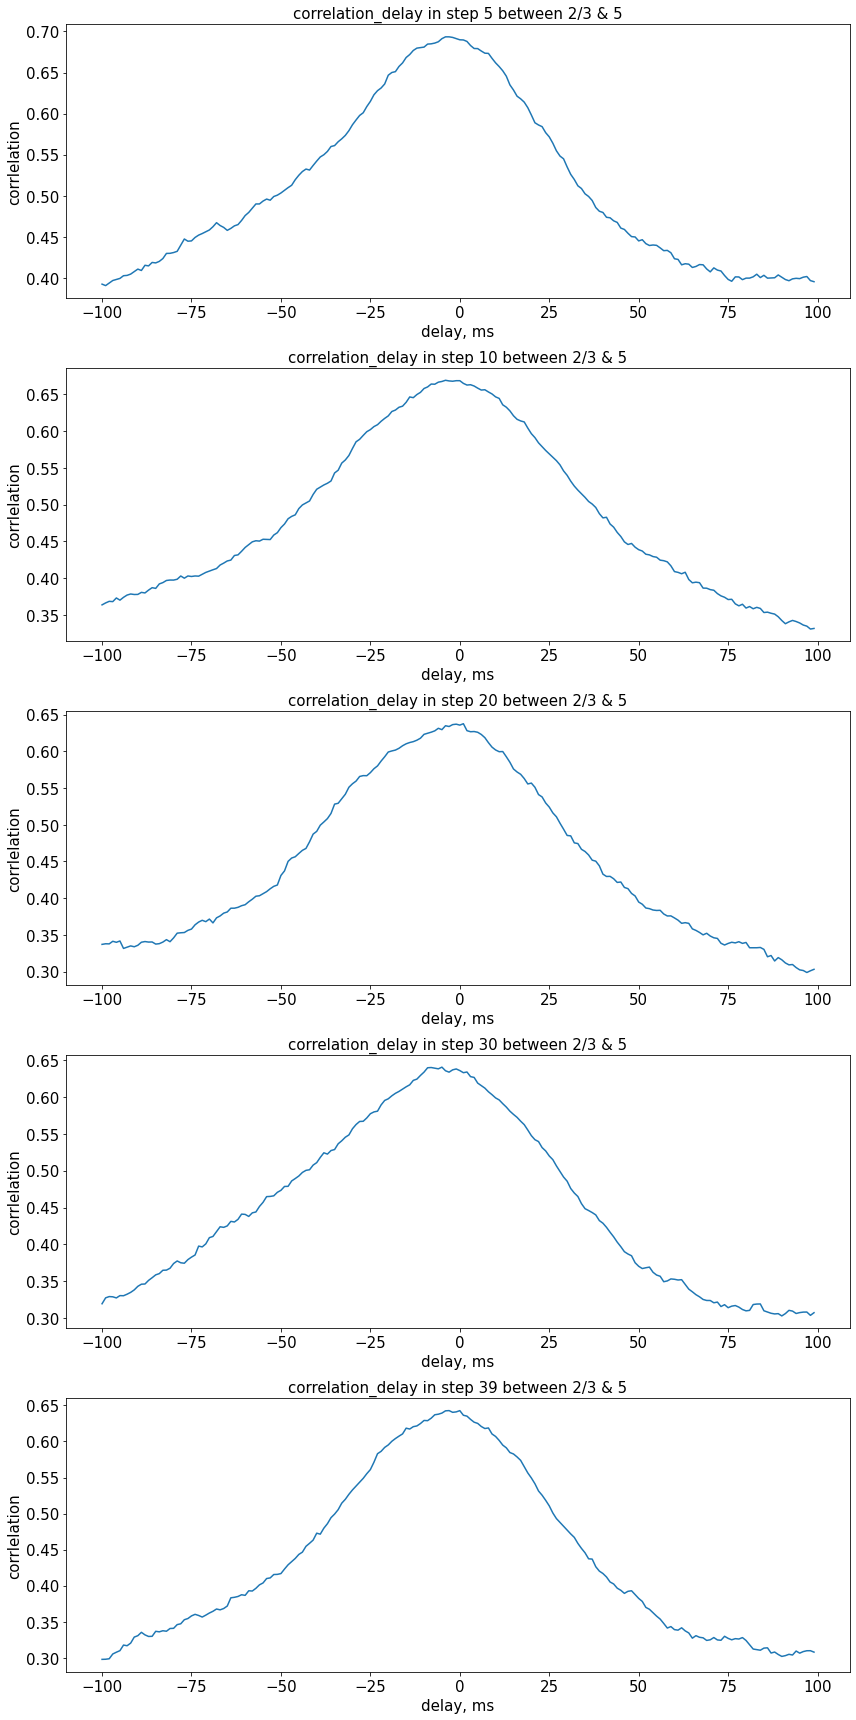

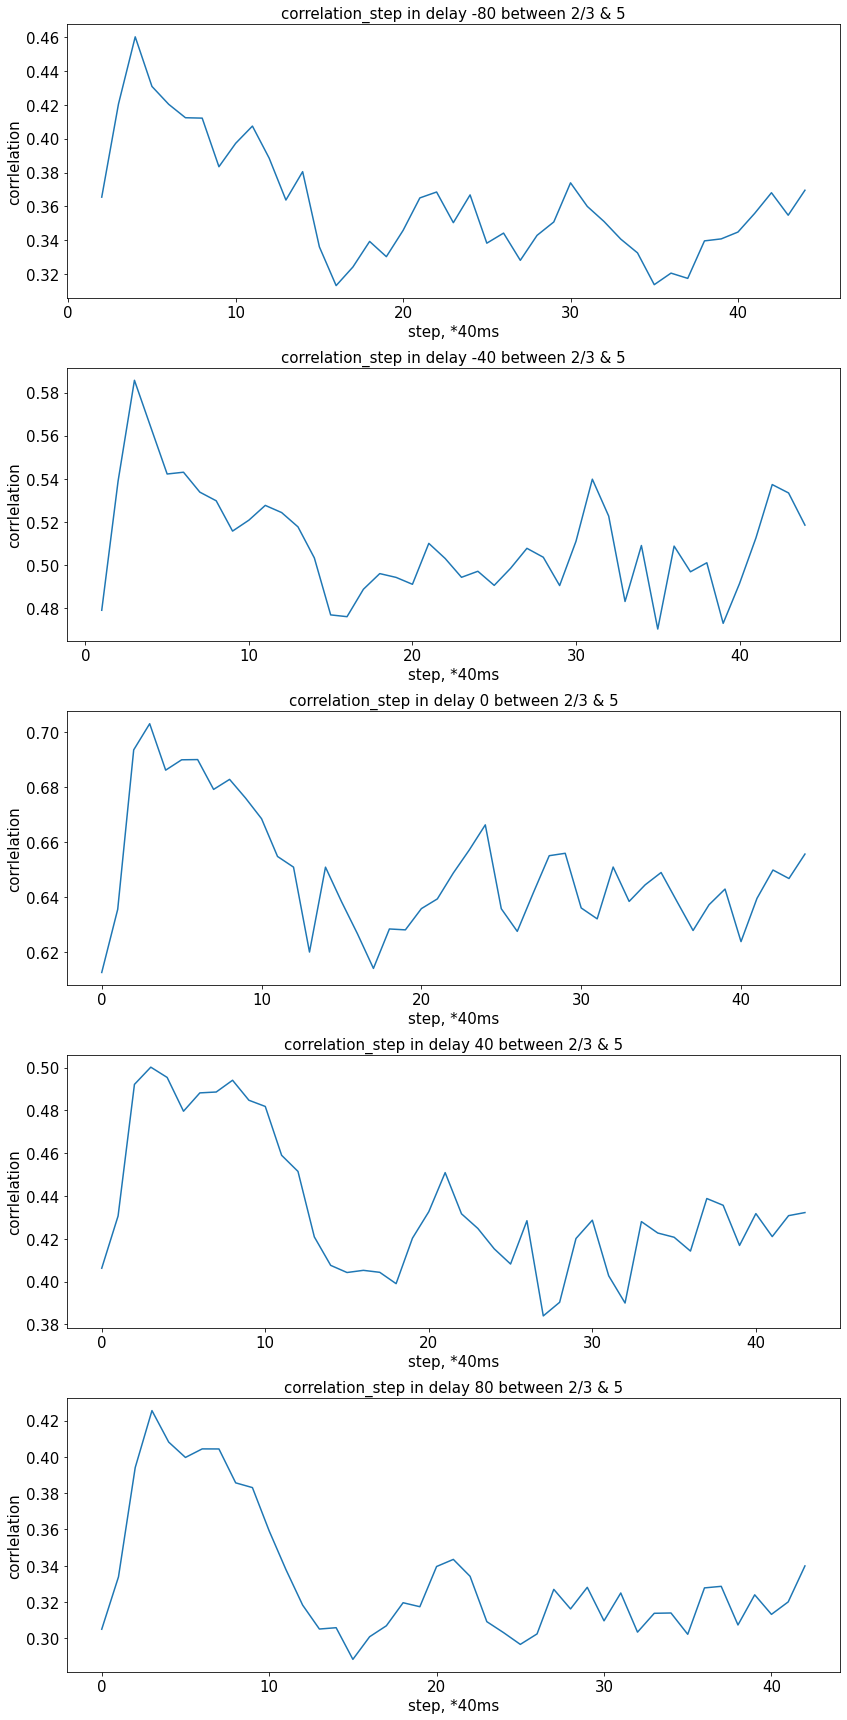

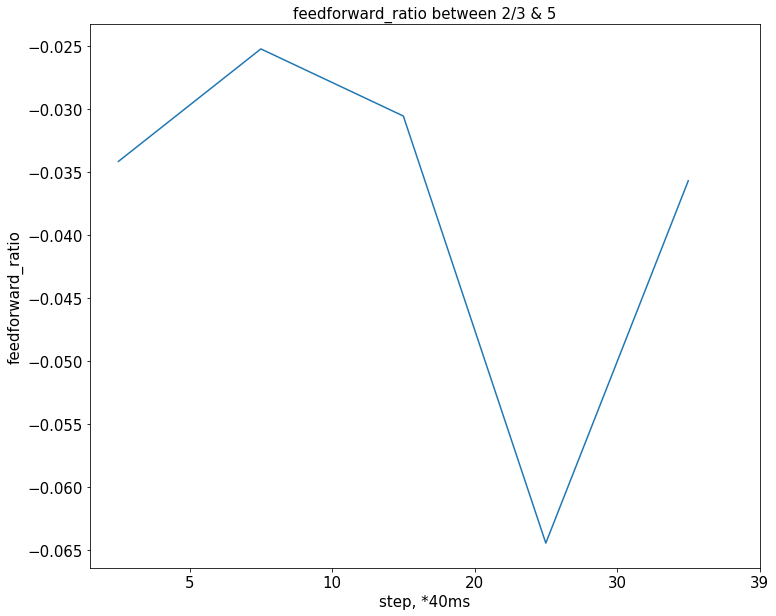

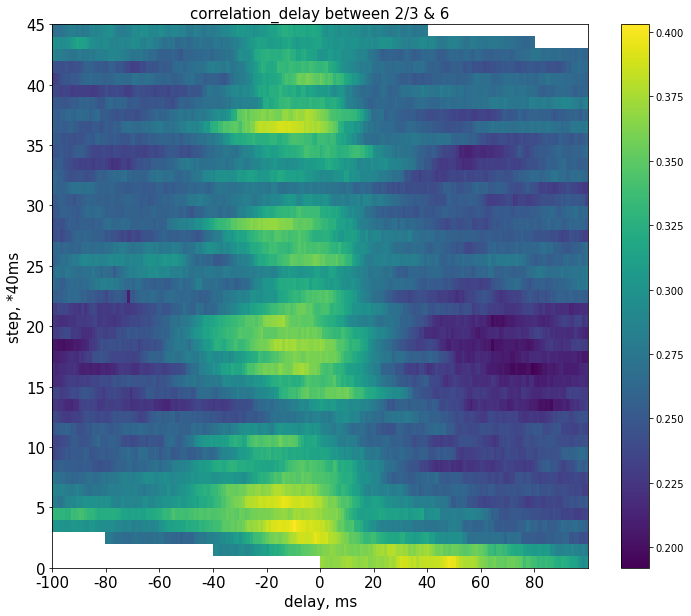

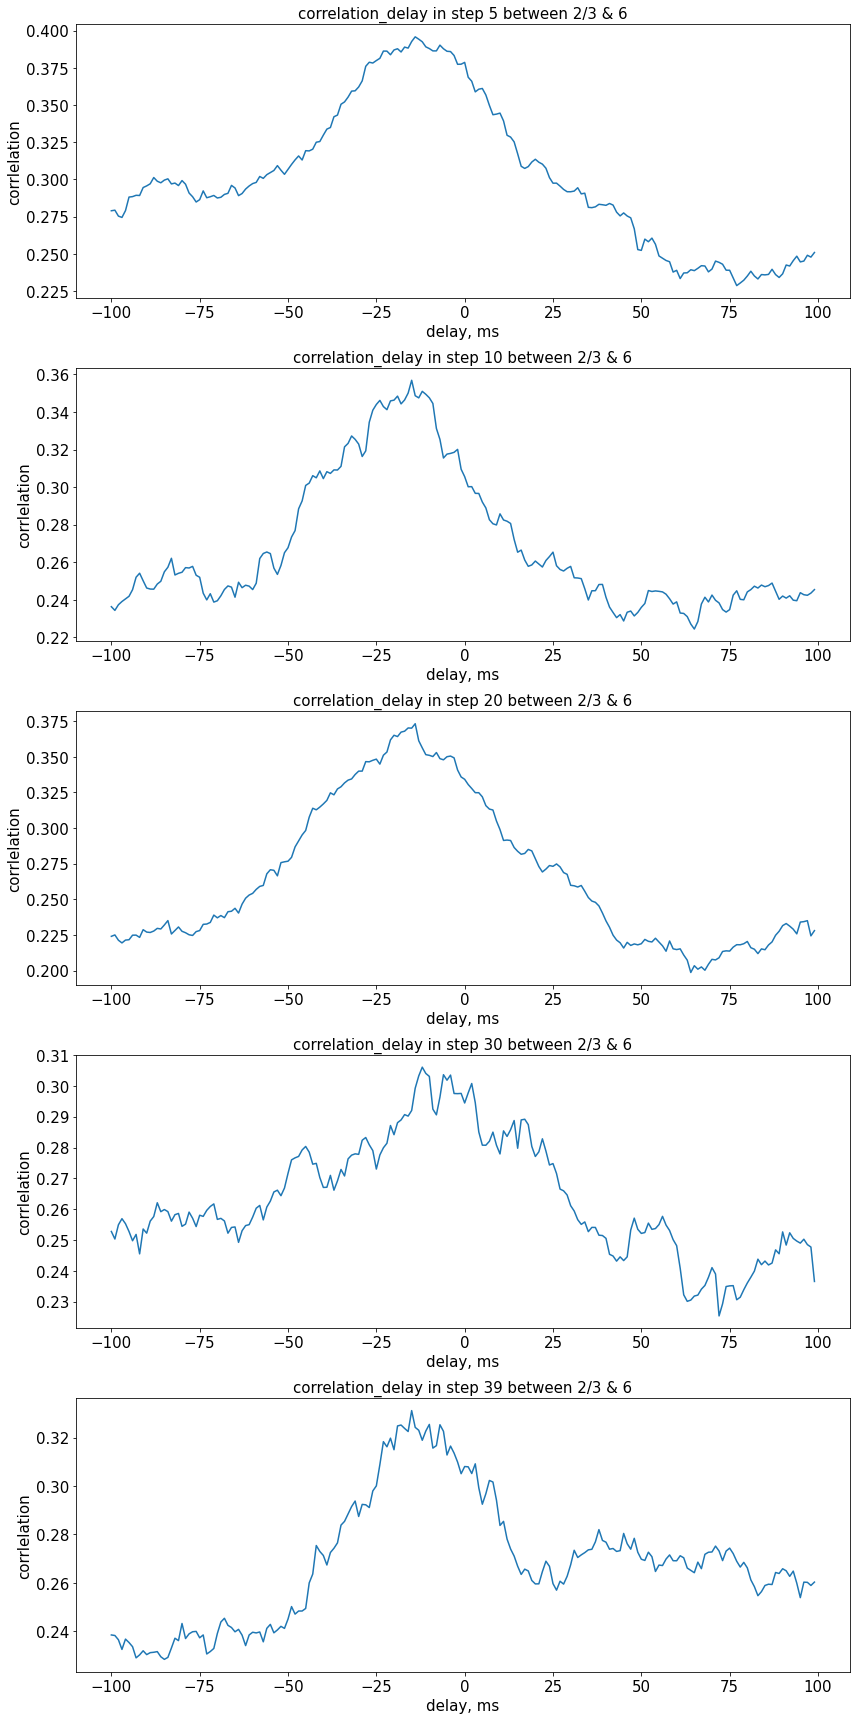

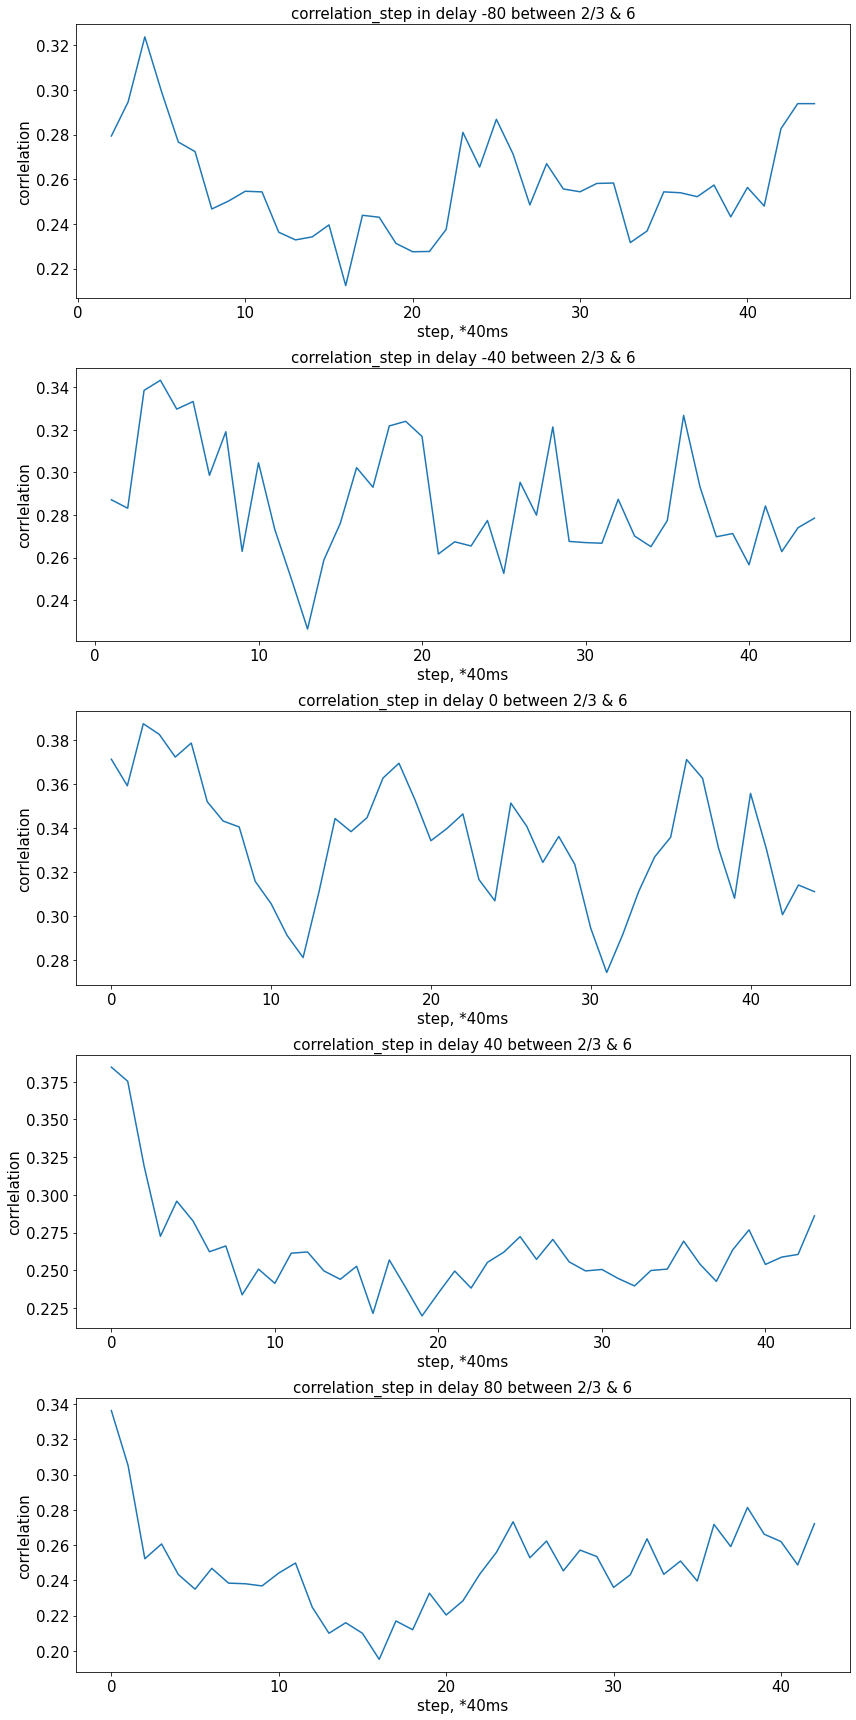

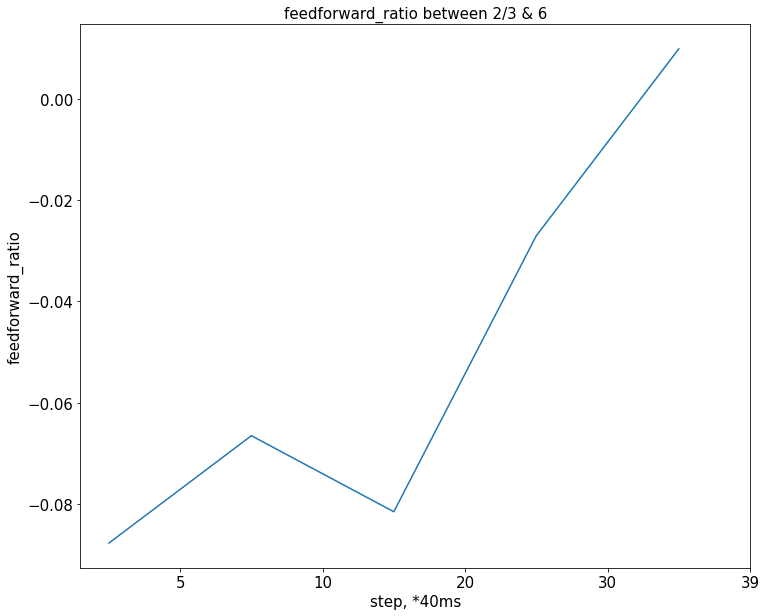

In [41]:
area = 'VISp'
layer_1 = '2/3'
layers_2 = ['2/3', '4', '5', '6']

corr_delay_matrix_layers = np.load('corr_delay_matrix_layers_755434585.npy', allow_pickle=True).item()

for j, layer_2 in enumerate(layers_2):
    layers_key = area + '_' + layer_1 + '_' + layer_2   
    corr_matrix_delay = corr_delay_matrix_layers[layers_key]

    plot_corr_delay_matrix_layer(corr_matrix_delay, layer_1, layer_2)
    plot_corr_delay_layer(corr_matrix_delay, layer_1, layer_2)
    plot_corr_step_layer(corr_matrix_delay, layer_1, layer_2)
    plot_feedforward_ratio_layer(corr_matrix_delay, layer_1, layer_2)

In [42]:
def get_feedforward_ratio_layers(corr_delay_matrix_layers, area, layers, step=5):

    feedforward_ratio_matrix = np.zeros((len(layers), len(layers)))
    feedforward_ratio_matrix_binary = np.zeros((len(layers), len(layers)))

    for i, layer_1 in enumerate(layers):
        for j, layer_2 in enumerate(layers):
            layers_key = area + '_' + layer_1 + '_' + layer_2
            corr_matrix_delay = corr_delay_matrix_layers[layers_key]
            feedforward_ratio_matrix[i, j] = get_feedforward_ratio(corr_matrix_delay, step=step)
            if feedforward_ratio_matrix[i, j] > 0:
                feedforward_ratio_matrix_binary[i, j] = 1
            else:
                feedforward_ratio_matrix_binary[i, j] = -1

    return feedforward_ratio_matrix, feedforward_ratio_matrix_binary

def get_ff_fd_ratio_layers(feedforward_ratio_matrix, layers):

    feedforward_num = np.zeros(len(layers))
    feedback_num = np.zeros(len(layers))
    ff_fd_ratio = np.zeros(len(layers))

    for i, layer in enumerate(layers):
        feedforward_num[i] = len(np.where(feedforward_ratio_matrix[i, :]>0)[0])
        feedback_num[i] = len(np.where(feedforward_ratio_matrix[i, :]<0)[0])
        ff_fd_ratio[i] = (feedforward_num[i]-feedback_num[i])/(feedforward_num[i]+feedback_num[i])

    return feedforward_num, feedback_num, ff_fd_ratio


def plot_ff_ratio_matrix_layers(feedforward_ratio_matrix, feedforward_ratio_matrix_binary, layers):

    fig, axes = plt.subplots(nrows=2, figsize=(12, 24))

    im_0 = axes[0].pcolormesh(feedforward_ratio_matrix)
    axes[0].set_xticks(range(len(layers))+np.array([0.5]))
    axes[0].set_xticklabels(layers)
    axes[0].set_yticks(range(len(layers))+np.array([0.5]))
    axes[0].set_yticklabels(layers)
    axes[0].tick_params(axis='both', labelsize=15)
    axes[0].set_title(f'feedforward_ratio_matrix', fontsize=15)
    cbar_0 = fig.colorbar(im_0, ax=axes[0])
    cbar_0.ax.tick_params(labelsize=13)

    im_1 = axes[1].pcolormesh(feedforward_ratio_matrix_binary)
    axes[1].set_xticks(range(len(layers))+np.array([0.5]))
    axes[1].set_xticklabels(layers)
    axes[1].set_yticks(range(len(layers))+np.array([0.5]))
    axes[1].set_yticklabels(layers)
    axes[1].tick_params(axis='both', labelsize=15)
    axes[1].set_title(f'feedforward_ratio_matrix_binary', fontsize=15)

    cbar_1 = fig.colorbar(im_1, ax=axes[1])
    cbar_1.ax.tick_params(labelsize=13)

    plt.show()

    return

def plot_ff_ratio_changing_layers(feedforward_ratio_matrix, layers):

    f, axes = plt.subplots(nrows=len(layers), ncols=1, figsize=(12, 24))

    for i, layer in enumerate(layers):
        
        axes[i].plot(np.array(range(len(layers))), feedforward_ratio_matrix[i, :])
        axes[i].hlines(y=0, xmin=0, xmax=len(layers), colors = "r", linestyles = "dashed")
        axes[i].bar(np.array(range(len(layers))), feedforward_ratio_matrix[i, :], width=0.6, tick_label=layers, fc='c')
        axes[i].set_ylabel(f'{layer}', fontsize=15)
        axes[i].tick_params(axis='both', labelsize=15)

    f.suptitle('ff_ratio across layers', verticalalignment='bottom', fontsize=18)
    plt.tight_layout()
    plt.show()

    return

def plot_ff_fd_layers(feedforward_num, feedback_num, layers):

    f, ax = plt.subplots(figsize=(24, 12))
    
    x = np.array(range(len(layers)))
    width=0.4
    ax.bar(x, feedforward_num, width=width, label='feedforward_num', fc='c')
    ax.bar(x+np.array([width]), feedback_num, width=width, label='feedback_num', tick_label=layers, fc='r')
    ax.legend(fontsize=15)

    # show num on the bar
    for a, b in zip(x, feedforward_num):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)
    for a, b in zip(x+width, feedback_num):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)

    ax.tick_params(axis='both', labelsize=15)
    ax.set_title(f'feedforward & feedback nums of different layers', fontsize=15)
    plt.show()
    return

def plot_ff_fd_ratio_layers(ff_fd_ratio, layers):

    f, ax = plt.subplots(figsize=(18, 10))

    ax.plot(np.array(range(len(layers))), ff_fd_ratio)
    ax.bar(np.array(range(len(layers))), ff_fd_ratio, width=0.6, tick_label=layers, fc='c')
    ax.hlines(y=0, xmin=0, xmax=len(layers), colors = "r", linestyles = "dashed")
    ax.set_ylabel(f'ff_fd_ratio', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_title('ff_fd_ratio across layers', fontsize=15)

    plt.show()

    return

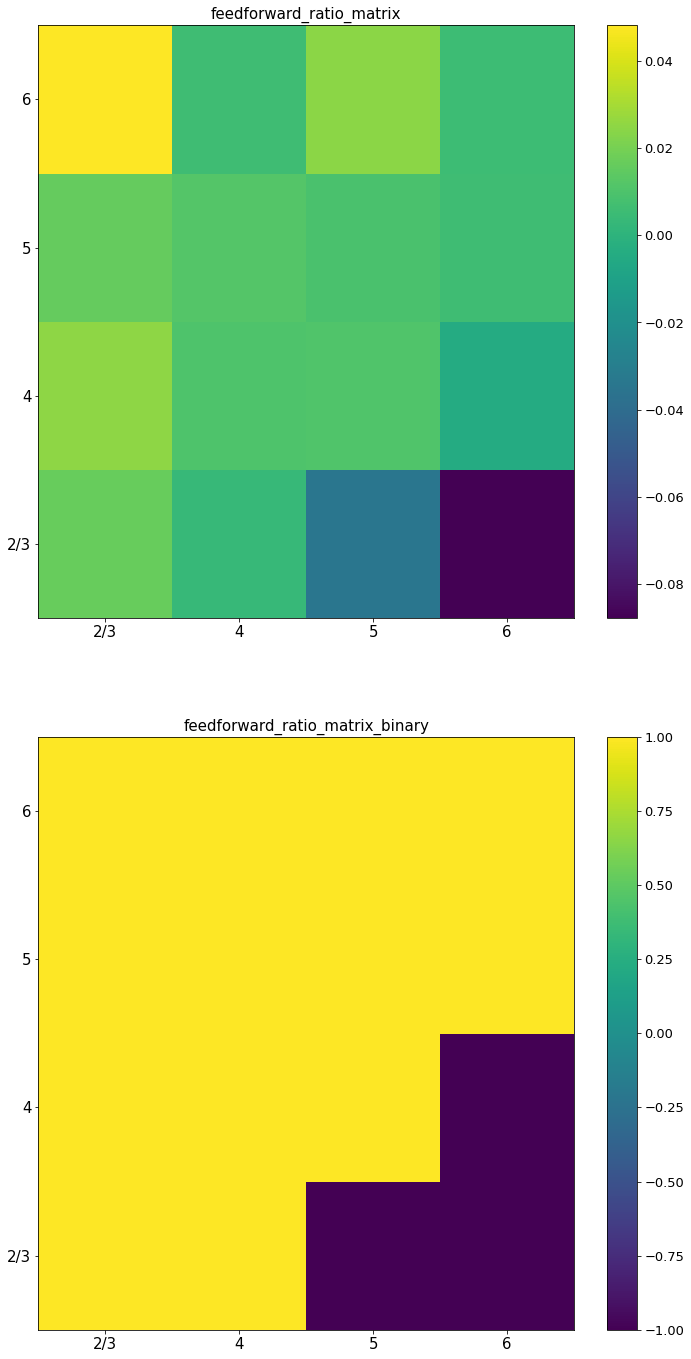

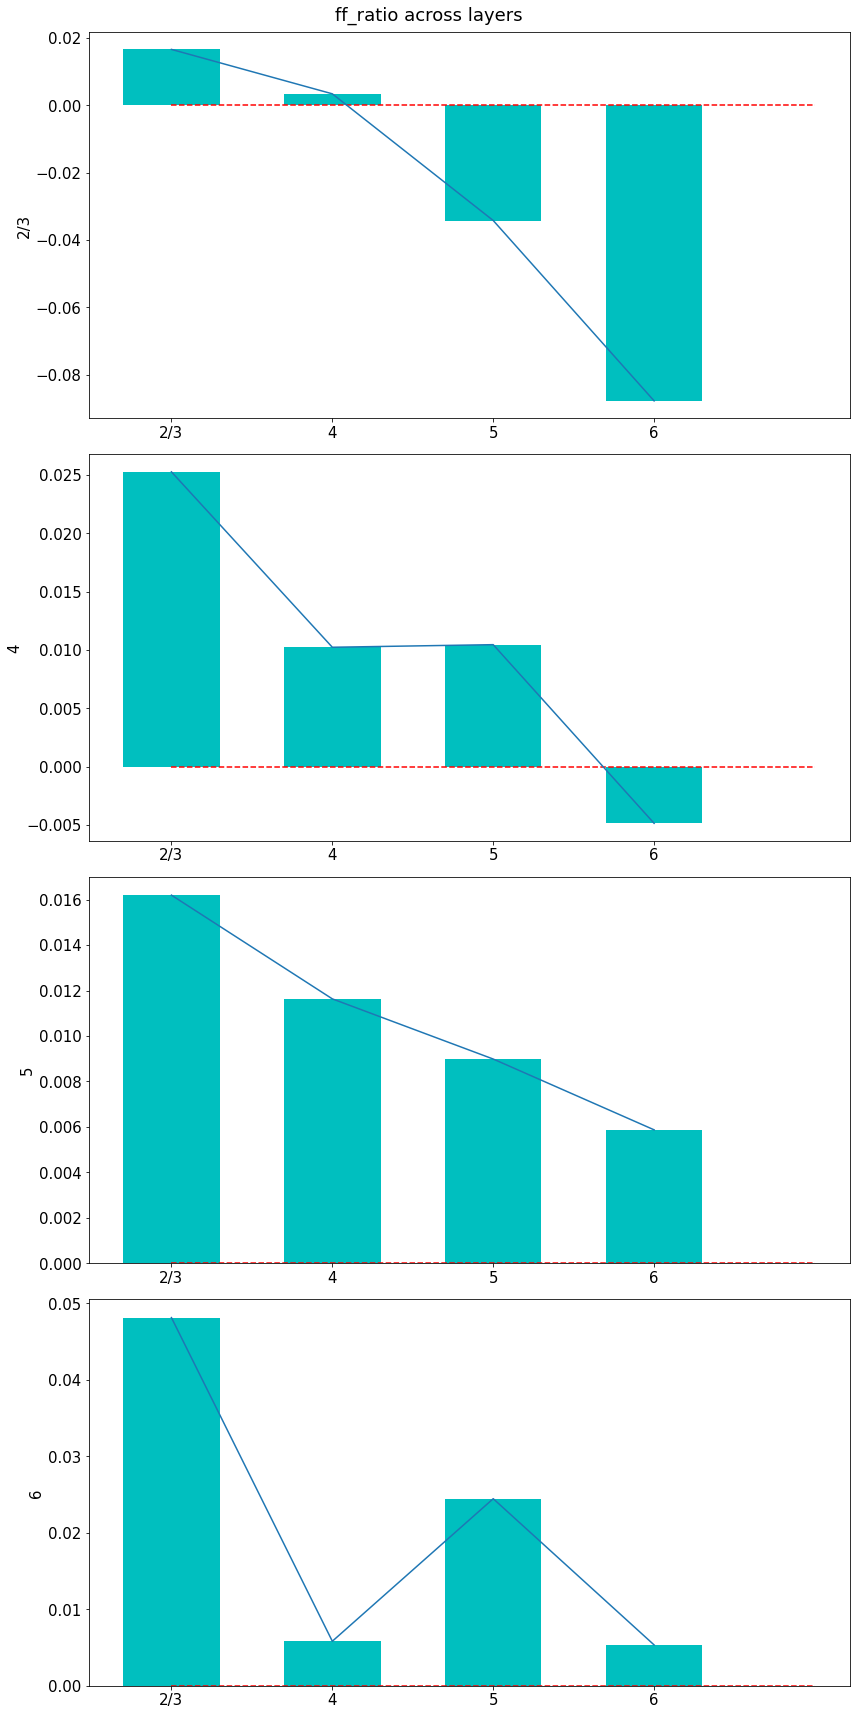

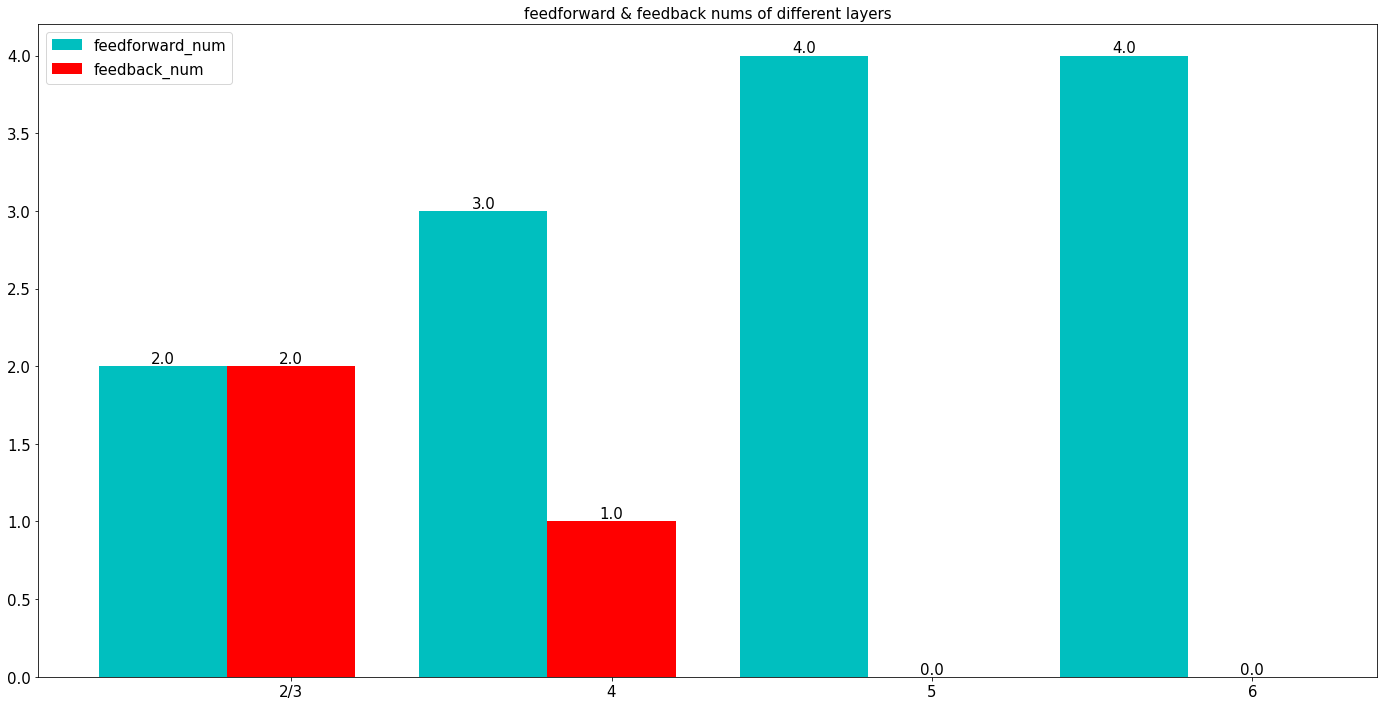

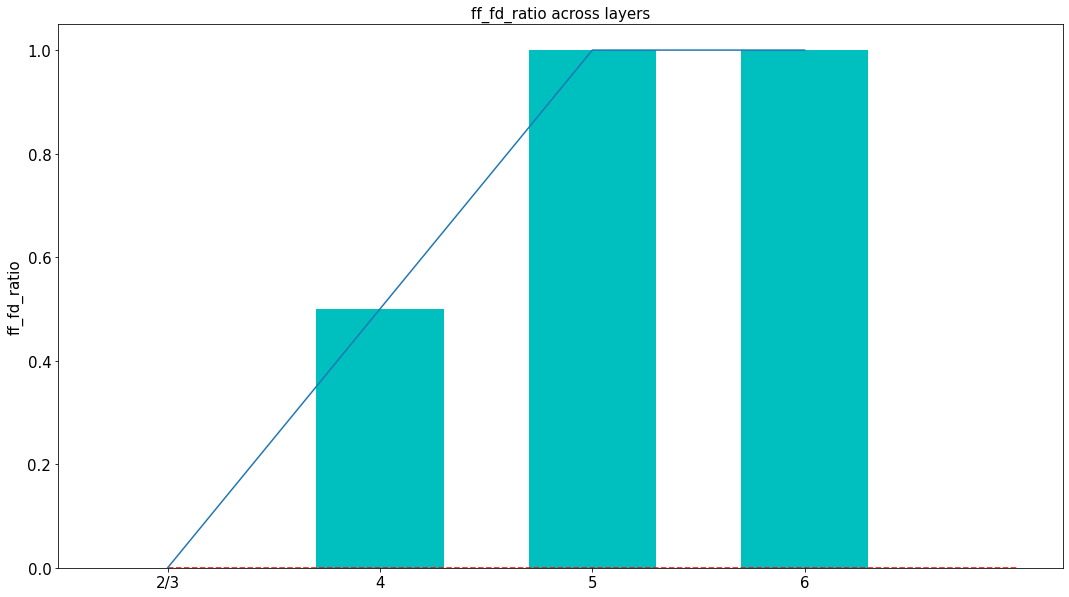

In [43]:
area = 'VISp'
layers = ['2/3', '4', '5', '6']

corr_delay_matrix_layers = np.load('corr_delay_matrix_layers_755434585.npy', allow_pickle=True).item()

feedforward_ratio_matrix, feedforward_ratio_matrix_binary = get_feedforward_ratio_layers(corr_delay_matrix_layers, area, layers)

plot_ff_ratio_matrix_layers(feedforward_ratio_matrix, feedforward_ratio_matrix_binary, layers)
plot_ff_ratio_changing_layers(feedforward_ratio_matrix, layers)

feedforward_num, feedback_num, ff_fd_ratio = get_ff_fd_ratio_layers(feedforward_ratio_matrix, layers)

plot_ff_fd_layers(feedforward_num, feedback_num, layers)
plot_ff_fd_ratio_layers(ff_fd_ratio, layers)

In [51]:
def cross_val_FA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def intra_dim_FA(des_mat):
    
    N, n_features = des_mat.shape

    # # select proper latent dimensions from [1, p-1]
    # cv_log_like = np.zeros(n_features-1)
    # for i in range(n_features-1):
    #     latent_dim = i + 1
    #     cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    # latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions from [1, p-1]
    if n_features > 20:
        # as n_features is more, cv_log_like is more
        # so to save time, limit 20 possible dim to try
        start_feature = n_features - 20
        cv_log_like = np.zeros(20)
        features = range(n_features)[start_feature:]
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)     
    else:
        cv_log_like = np.zeros(n_features-1)
        features = np.arange(n_features-1) + 1
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = features[np.argmax(cv_log_like) + 1]

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim


def get_intra_dim_layer(area, layers, layer_units, stim_table):

    intra_dim_layer = np.zeros(len(layers))

    for i, layer in enumerate(layers):
        des_mat = get_design_matrix_layer(area, layer, stim_table, layer_units)
        intra_dim_layer[i] = intra_dim_FA(des_mat)

    print('intra_dim_layer', intra_dim_layer)

    return intra_dim_layer

def plot_intra_dim_layers(layers, layer_units_num, intra_dim_layer):

    # intra_dimension for all layers
    x = np.array(range(len(layers)))
    width=0.4
    f, ax = plt.subplots(figsize=(24, 12))
    ax.bar(x, layer_units_num, width=width, label='units',fc='y')
    ax.bar(x+np.array([width]), intra_dim_layer, width=width, label='intra_dimensions', tick_label=layers, fc='r')
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=15)

    # show num on the bar
    for a, b in zip(x, layer_units_num):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)
    for a, b in zip(x+width, intra_dim_layer):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)

    ax.set_title(f'intra_dim & units in different layers', fontsize=15)
    plt.show()

    return

intra_dim_layer [2. 2. 8. 4.]


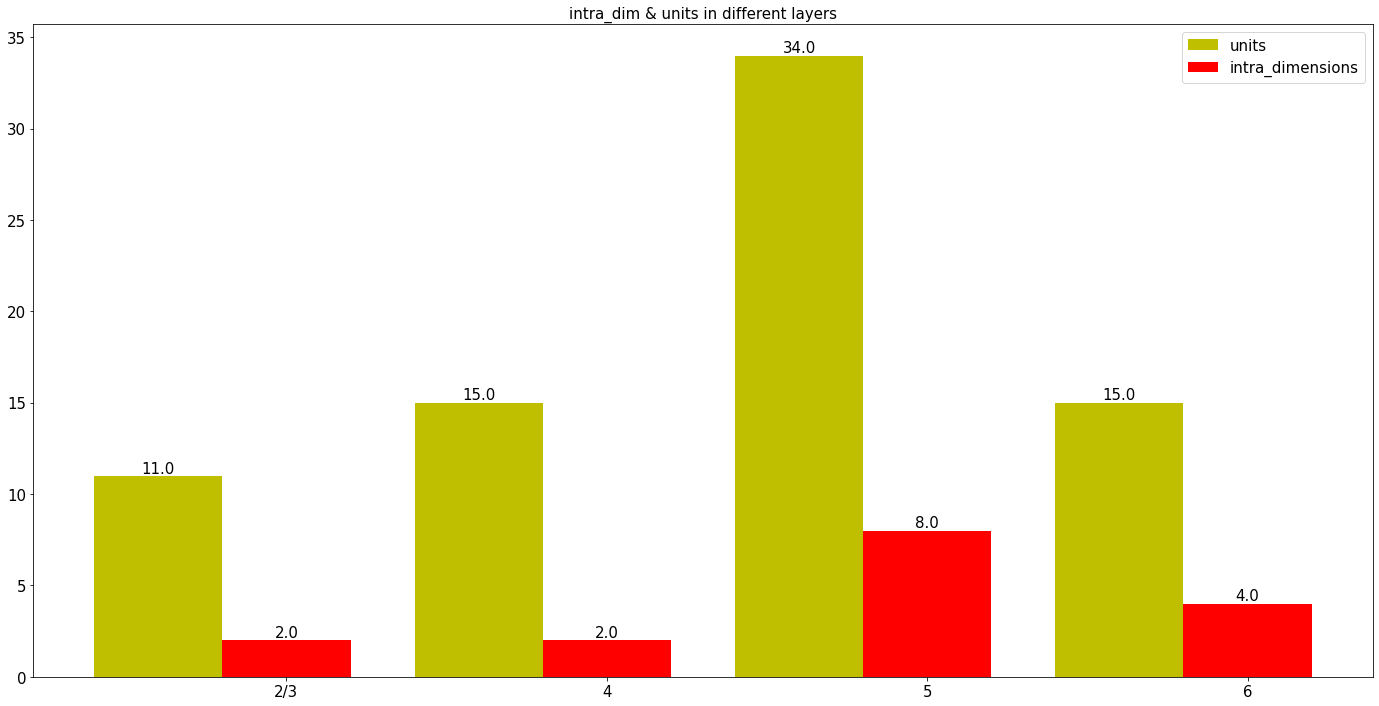

In [52]:
session_id = 755434585
session = selected_sessions[session_id]
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam']
area = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')

layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()
layer_units_num = get_layer_units_num(areas, layers, layer_units)[0, :]

intra_dim_layer = get_intra_dim_layer(area, layers, layer_units, stim_table=drift_stim_table)
np.save('intra_dim_layer_755434585', intra_dim_layer)

# intra_dim_layer = np.load('intra_dim_layer_755434585.npy')
plot_intra_dim_layers(layers, layer_units_num, intra_dim_layer)

### Task8 Relation between area_subspace & layer_channel

In [53]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def get_design_matrix(area, stim_table):
    """get_design_matrix design_matrix for further analysis

    Reshape response_matrix from (stims, bins, units) to (stims*bins, units)/(n_samples, units)

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        design_matrix, shape (n_samples, units)
    """

    response_matrix = spike_matrix(area=area, stim_table=stim_table)
    design_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return design_matrix

In [71]:
def cross_val_pCCA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(des_mat_1, des_mat_2):
    
    des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)

    N, n_features = des_mat.shape
    _, n_features_1 = des_mat_1.shape
    _, n_features_2 = des_mat_2.shape

    # # select proper latent dimensions from [1, n_features-1]
    # cv_log_like = np.zeros(n_features-1)
    # for i in range(n_features-1):
    #     latent_dim = i + 1
    #     cv_log_like[i] = cross_val_pCCA(des_mat, latent_dim)

    # latent_dim_log_like = np.argmax(cv_log_like) + 1
    # print('latent_dim_log_like', latent_dim_log_like)

    # select proper latent dimensions from [1, p-1]
    if n_features > 20:
        # as n_features is more, cv_log_like is more
        # so to save time, limit 20 possible dim to try
        start_feature = n_features - 20
        cv_log_like = np.zeros(20)
        features = range(n_features)[start_feature:]
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)     
    else:
        cv_log_like = np.zeros(n_features-1)
        features = np.arange(n_features-1) + 1
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = features[np.argmax(cv_log_like) + 1]

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]
    print('latent_dim', latent_dim)

    # use the proper latent_dim to fit
    fa = FactorAnalysis(n_components=latent_dim)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    return latent_dim, (load_mat_1, load_mat_2)

def get_inter_dim_layers(area_1, area_2, layers, layer_units, stim_table):

    inter_dim_layers = np.zeros(len(layers))
    pCCA_load_mat_1 = {}
    pCCA_load_mat_2 = {}

    des_mat_1 = get_design_matrix(area_1, stim_table)
    for i, layer in enumerate(layers):
        name = area_1 + '_' + area_2 + layer
        des_mat_2 = get_design_matrix_layer(area_2, layer, stim_table, layer_units)
        inter_dim_layers[i], (pCCA_load_mat_1[name], pCCA_load_mat_2[name]) = inter_dim_pCCA(des_mat_1, des_mat_2)
            
        print('inter_dim_layers', inter_dim_layers[i])

    return inter_dim_layers, pCCA_load_mat_1, pCCA_load_mat_2

def plot_inter_dim_layers(area, layers, intra_dim_LGd, intra_dim_layer, inter_dim_layers):
    # inter_dimension across every two areas

    f, ax = plt.subplots(figsize=(14, 8))

    width=0.25
    x = np.array(range(len(layers)))
    intra_dim_area_1 = np.ones_like(x) * intra_dim_LGd
    intra_dim_area_2 = intra_dim_layer

    ax.bar(x, intra_dim_area_1, width=width, label='intra_dim_LGd', fc='r') 
    ax.bar(x+np.array([width]), inter_dim_layers, width=width, label='inter_dim', fc='g')
    ax.bar(x+np.array([2*width]), intra_dim_area_2, width=width, label='intra_dim_layer', tick_label=layers, fc='b')
    ax.set_ylabel(f'dim', fontsize=15)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=15)

    for a, b in zip(x, intra_dim_area_1):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)
    for a, b in zip(x+width, inter_dim_layers[i, :]):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)
    for a, b in zip(x+2*width, intra_dim_area_2):
        ax.text(a, b, b, ha='center', va='bottom', fontsize=15)

    ax.set_title('inter_dimension across LGd & VISp layers', verticalalignment='bottom', fontsize=18)
    plt.tight_layout()
    plt.show()

In [72]:
session_id = 755434585
session = selected_sessions[session_id]
area_1 = 'LGd'
area_2 = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')
layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()

inter_dim_layers, pCCA_load_mat_1_layers, pCCA_load_mat_2_layers = get_inter_dim_layers(area_1, area_2, layers, layer_units, stim_table=drift_stim_table)
np.save('inter_dim_layers_755434585', inter_dim_layers)
np.save('pCCA_load_mat_1_layers_755434585', pCCA_load_mat_1_layers)
np.save('pCCA_load_mat_2_layers_755434585', pCCA_load_mat_2_layers)

intra_dim_LGd = np.load('intra_dim_area_755434585.npy')[6]
intra_dim_layer = np.load('intra_dim_layer_755434585.npy')
# inter_dim_layers = np.load('inter_dim_layers_755434585.npy')
plot_inter_dim_layers(area_2, layers, intra_dim_LGd, intra_dim_layer, inter_dim_layers)

In [66]:
def get_vectors_angle(v1, v2):
    """get_vectors_angle angle of two vectors, v1 & v2

    Arguments:
        v1 -- vector
        v2 -- vector

    Returns:
        angle
    """

    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.around(np.dot(unit_v1, unit_v2), 3)
    rad = np.arccos(dot_product)
    angle = np.rad2deg(rad)

    return angle


def cca_subspace_dims_angle_layer(area_x, area_y1, layer_y2, layer_units, stim_table):
    """cca_subspace_dims_angle, generalize canonical dimension across subspaces via CCA

    To identify the relation between subspaces got by (cca for area_x & area_y1) and (cca for area_x & area_y2)
    Use cca for area_x & area_y1, we can get correlated canoical dimensions (w_xy1) of area_x for information flow with area_y1;
    Use cca for area_x & area_y2, we can get correlated canoical dimensions (w_xy2) of area_x for information flow with area_y2;
    Then, by calculating the angle between canoical dimensions in w_xy1 and canoical dimensions in w_xy2,
    we find that when area_x exchange information with area_y1 & area_y2, it use different subspaces.

    there are three relations of information flow between area_x, area_y1, area_y2:
    1. area_x  --->  area_y1 & area_x  --->  area_y2
    2. area_y1  --->  area_x & area_x  --->  area_y2
    3. area_y1  --->  area_x & area_y2  --->  area_x

    Arguments:
        area_x -- an area have information flow with both area_y1 & area_y2
        area_y1 -- an area have information flow with area_x
        area_y2 -- an area have information flow with area_x
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        dims_angle -- the angle of canoical dimensions in w_xy1 and w_xy2
    """

    des_mat_x = get_design_matrix(area_x, stim_table)
    des_mat_y1 = get_design_matrix(area_y1, stim_table)
    des_mat_y2 = get_design_matrix_layer(area_y1, layer_y2, stim_table, layer_units)

    _, (w_xy1, _), _ = corr_area_pairs(des_mat_x, des_mat_y1)
    _, (w_xy2, _), _ = corr_area_pairs(des_mat_x, des_mat_y2)
    # print('w_xy1', w_xy1.shape)
    # print('w_xy2', w_xy2.shape)

    dims_angle = np.zeros(w_xy1.shape[1])
    for i in range(w_xy1.shape[1]):
        dims_angle[i] = get_vectors_angle(w_xy1[:, i], w_xy2[:, i])
    # subspaces_angle = np.rad2deg(subspace_angles(w_xy1, w_xy2))

    return dims_angle

def plot_dims_angles_area_layer(area_1, area_2, layers, dims_angles_layer):

    fig, ax = plt.subplots(figsize=(14, 8))
     
    ax.plot(range(len(layers)), dims_angles_layer)
    ax.set_xticks(range(len(layers)))
    ax.set_xticklabels(layers)
    ax.set_ylabel('dims_angles', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_title(f'{area_2} & its layers in {area_1}', fontsize=15)

    # fig.suptitle(f'dims_angles in {area_1}', verticalalignment='bottom', fontsize=18)
    fig.tight_layout()
    plt.show()

    return

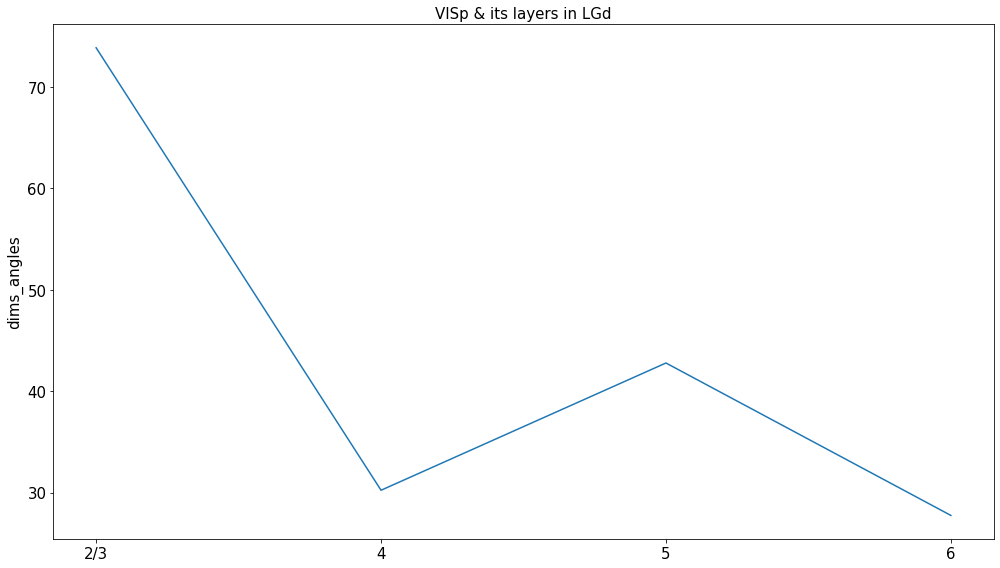

In [67]:
session_id = 755434585
session = selected_sessions[session_id]
area_1 = 'LGd'
area_2 = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')

# layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()
# dims_angles_layer = np.zeros(len(layers))
# for i, layer in enumerate(layers):
#     dims_angles_layer[i] = cca_subspace_dims_angle_layer(area_1, area_2, layer, layer_units, stim_table=drift_stim_table)[0]

# np.save('dims_angles_layer_755434585', dims_angles_layer)

dims_angles_layer = np.load('dims_angles_layer_755434585.npy')
plot_dims_angles_area_layer(area_1, area_2, layers, dims_angles_layer)

In [ ]:
def pCCA_subspaces_angle_layers(area_x, area_y1, layer_y2, pCCA_load_mat_1_areas, pCCA_load_mat_1_layers):
    """pCCA_subspaces_angle, get angles of subspaces via pCCA

    To identify the relation between subspaces got by (pCCA for area_x & area_y1) and (pCCA for area_x & area_y2)
    Use pCCA for area_x & area_y1, we can get information flow subspace (spanned by load_mat_xy1) of area_x and area_y1;
    Use pCCA for area_x & area_y2, we can get information flow subspace (spanned by load_mat_xy2) of area_x and area_y2;
    Then, by calculating the angle between these subspaces load_mat_xy1 & load_mat_xy2,
    we find that when area_x exchange information with area_y1 & area_y2, it use different subspaces.

    there are three relations of information flow between area_x, area_y1, area_y2:
    1. area_x  --->  area_y1 & area_x  --->  area_y2
    2. area_y1  --->  area_x & area_x  --->  area_y2
    3. area_y1  --->  area_x & area_y2  --->  area_x

    Arguments:
        area_x -- an area have information flow with both area_y1 & area_y2
        area_y1 -- an area have information flow with area_x
        area_y2 -- an area have information flow with area_x
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        subspaces_angle -- the angle of subspaces load_mat_xy1 & load_mat_xy2
    """

    # des_mat_x = get_design_matrix(area_x, stim_table)
    # des_mat_y1 = get_design_matrix(area_y1, stim_table)
    # des_mat_y2 = get_design_matrix(area_y2, stim_table)

    # _, (load_mat_xy1, _) = inter_dim_pCCA(des_mat_x, des_mat_y1)
    # _, (load_mat_xy2, _) = inter_dim_pCCA(des_mat_x, des_mat_y2)
    # print('load_mat_xy1', load_mat_xy1.shape)
    # print('load_mat_xy2', load_mat_xy2.shape)

    name_1 = area_x + '_' + area_y1
    name_2 = area_x + '_' + area_y1 + layer_y2
    load_mat_xy1 = pCCA_load_mat_1_areas[name_1]
    load_mat_xy2 = pCCA_load_mat_1_layers[name_2]

    subspaces_angle = np.rad2deg(subspace_angles(load_mat_xy1.T, load_mat_xy2.T)[0])

    return subspaces_angle

def plot_subspaces_angles_layers(area_1, area_2, layers, subspaces_angles_layers):

    fig, ax = plt.subplots(figsize=(12, 24))
        
    ax.plot(range(len(layers)), subspaces_angles_layers)
    ax.set_xticks(range(len(layers)))
    ax.set_xticklabels(layers)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_ylabel(f'subspaces_angles', fontsize=15)
    ax.set_title(f'{area_2} & its layers in {area_1}', fontsize=15)

    # fig.suptitle(f'subspaces_angles in {area_1}', verticalalignment='bottom', fontsize=18)
    fig.tight_layout()
    plt.show()

    return

In [ ]:
session_id = 755434585
session = selected_sessions[session_id]
area_1 = 'LGd'
area_2 = 'VISp'
layers = ['2/3', '4', '5', '6']
drift_stim_table = session.get_stimulus_table('drifting_gratings')
layer_units = np.load('VIS_layer_units_'+f'{session_id}'+'.npy', allow_pickle=True).item()

pCCA_load_mat_1_layers = np.load('pCCA_load_mat_1_layers_755434585.npy', allow_pickle=True).item()
pCCA_load_mat_1_areas = np.load('pCCA_load_mat_1_755434585.npy', allow_pickle=True).item()
subspaces_angles_layers = np.zeros(len(layers))

for i, layer in enumerate(layers):
    subspaces_angles_layers[i] = pCCA_subspaces_angle_layers(area_1, area_2, layer, pCCA_load_mat_1_areas, pCCA_load_mat_1_layers)

np.save('subspaces_angles_layers_755434585', subspaces_angles_layers)

# subspaces_angles_layers = np.load('subspaces_angles_layers_755434585.npy')
plot_subspaces_angles_layers(area_1, area_2, layers, subspaces_angles_layers)

***********************************************************************
Below Code copy from part4 for debug
***********************************************************************

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session = cache.get_session_data(755434585)
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,225,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.891887,2,drifting_gratings,1587.893537,1,2.00165,246
3799,0.8,270,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1588.894403,2,drifting_gratings,1590.896063,2,2.00166,247
3800,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1591.896927,2,drifting_gratings,1593.898597,8,2.00167,248
3801,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1594.899423,2,drifting_gratings,1596.901083,2,2.00166,249
3802,0.8,315,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1597.901957,2,drifting_gratings,1599.903567,2,2.00161,250


In [105]:
def cross_val_FA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def intra_dim_FA(des_mat):
    
    N, n_features = des_mat.shape

    # select proper latent dimensions from [1, p-1]
    cv_log_like = np.zeros(n_features-1)
    for i in range(n_features-1):
        latent_dim = i + 1
        cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim, cv_log_like, latent_dim_log_like


def get_intra_dim_area(areas, stim_table):

    intra_dim_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        des_mat = get_design_matrix(area, stim_table)
        intra_dim_area[i] = intra_dim_FA(des_mat)

    print('intra_dim_area', intra_dim_area)

    return intra_dim_area

def plot_intra_dim_areas(areas, units_area, intra_dim_area):

    # intra_dimension for all areas
    x = np.array(range(len(areas)))
    width=0.4
    plt.figure(figsize=(16, 10))
    plt.bar(x, units_area, width=width, label='units',fc='y')
    plt.bar(x+np.array([width]), intra_dim_area, width=width, label='intra_dimensions', tick_label=areas, fc='r')
    plt.legend()

    # show num on the bar
    for a, b in zip(x, units_area):
        plt.text(a, b, b, ha='center', va='bottom')
    for a, b in zip(x+width, intra_dim_area):
        plt.text(a, b, b, ha='center', va='bottom')

    plt.title(f'intra_dim & units in different areas')
    plt.show()

    return

latent_dim_log_like 32
latent_dim 14


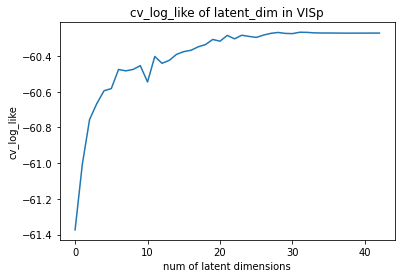

In [8]:
area = 'LGd'
des_mat = get_design_matrix(area, stim_table=drift_stim_table)
latent_dim, cv_log_like, latent_dim_log_like = intra_dim_FA(des_mat)
print('latent_dim_log_like', latent_dim_log_like)
print('latent_dim', latent_dim)

plt.figure()
plt.plot(cv_log_like)
plt.title(f'cv_log_like of latent_dim in VISp')
plt.xlabel('num of latent dimensions')
plt.ylabel('cv_log_like')
plt.show()